In [1]:
import pandas as pd
import numpy as np
import time

import scanpy as sc
from anndata.experimental.pytorch import AnnLoader

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchnet.meter import ClassErrorMeter, AverageValueMeter
# from torch_prototypes.modules import prototypical_network
import prototypical_network
from torch_prototypes.metrics import distortion, cost
from torch_prototypes.metrics.distortion import DistortionLoss
from  torch.distributions import multivariate_normal

import matplotlib.pyplot as plt
import seaborn as sns

import helper_fns
import vanilla_vae

import igraph as ig
from sklearn.decomposition import TruncatedSVD
from anndata import AnnData

import biomart

In [4]:
dataset_celltypist = sc.read("/Volumes/SSD/global.h5ad")
dataset_popv = sc.read("/Volumes/SSD/popv_immune.h5ad")
list_celltypes = dataset_celltypist.obs['Manually_curated_celltype'].unique().tolist()
list_celltypes = list(filter(lambda x: x not in ['Mast cells', 'pDC','Progenitor', 'Erythroid', 'Megakaryocytes'], list_celltypes))
list_filtered_celltypes = list(filter(lambda x: 'doublets' not in x, list_celltypes))
dataset_celltypist = dataset_celltypist[dataset_celltypist.obs['Manually_curated_celltype'].isin(list_filtered_celltypes)]

encoder_celltype = LabelEncoder()
encoder_celltype.fit(dataset_celltypist.obs['Manually_curated_celltype'])

list_ct = dataset_celltypist.obs['Manually_curated_celltype'].unique().tolist()
list_num_ct = encoder_celltype.transform(list_ct)
list_inner_nodes = ['Cross-tissue Immune Cell Atlas', 'B cell', 'Germinal center B cell', 'Myeloid', 'Dendritic cell',
                    'Macrophages', 'Monocytes', 'T & Innate lymphoid cells', 'CD4', 'T Naive', 'CD8', 
                    'Tissue-resident memory T (Trm) cells', 'NK']
all_nodes = list_ct + list_inner_nodes

encoder_celltype_inner = LabelEncoder()
encoder_celltype_inner.fit(list_inner_nodes)

def transfrom(x):
    if x in list_inner_nodes:
        return encoder_celltype_inner.transform([x])[0] + len(list_ct)
    else:
        return encoder_celltype.transform([x])[0]

g = ig.Graph()
g.add_vertices(len(all_nodes))
g.vs['name'] = np.append(encoder_celltype.inverse_transform(list(range(len(list_ct)))), encoder_celltype_inner.inverse_transform(list(range(len(list_inner_nodes)))))
g.add_edges([(transfrom('Cross-tissue Immune Cell Atlas'), transfrom('B cell')),
             (transfrom('Cross-tissue Immune Cell Atlas'), transfrom('Myeloid')),
             (transfrom('Cross-tissue Immune Cell Atlas'), transfrom('T & Innate lymphoid cells'))])
g.add_edges([(transfrom('B cell'), transfrom('ABCs')),
             (transfrom('B cell'), transfrom('Germinal center B cell')),
             (transfrom('B cell'), transfrom('Memory B cells')),
             (transfrom('B cell'), transfrom('Naive B cells')),
             (transfrom('B cell'), transfrom('Plasma cells')),
             (transfrom('B cell'), transfrom('Plasmablasts')),
             (transfrom('B cell'), transfrom('Pre-B')),
             (transfrom('B cell'), transfrom('Pro-B'))])
g.add_edges([(transfrom('Germinal center B cell'), transfrom('GC_B (I)')),
             (transfrom('Germinal center B cell'), transfrom('GC_B (II)'))])
g.add_edges([(transfrom('Myeloid'), transfrom('Cycling')),
             (transfrom('Myeloid'), transfrom('Dendritic cell')),
             (transfrom('Myeloid'), transfrom('Macrophages')),
             (transfrom('Myeloid'), transfrom('Monocytes'))])
g.add_edges([(transfrom('Dendritic cell'), transfrom('DC1')),
             (transfrom('Dendritic cell'), transfrom('DC2')),
             (transfrom('Dendritic cell'), transfrom('migDC'))])
g.add_edges([(transfrom('Macrophages'), transfrom('Alveolar macrophages')),
             (transfrom('Macrophages'), transfrom('Erythrophagocytic macrophages')),
             (transfrom('Macrophages'), transfrom('Intermediate macrophages')),
             (transfrom('Macrophages'), transfrom('Intestinal macrophages'))])
g.add_edges([(transfrom('Monocytes'), transfrom('Classical monocytes')),
             (transfrom('Monocytes'), transfrom('Nonclassical monocytes'))])
g.add_edges([(transfrom('T & Innate lymphoid cells'), transfrom('CD4')),
             (transfrom('T & Innate lymphoid cells'), transfrom('CD8')),
             (transfrom('T & Innate lymphoid cells'), transfrom('Cycling T&NK')),
             (transfrom('T & Innate lymphoid cells'), transfrom('ILC3')),
             (transfrom('T & Innate lymphoid cells'), transfrom('NK')),
             (transfrom('T & Innate lymphoid cells'), transfrom('T_CD4/CD8'))])
g.add_edges([(transfrom('CD4'), transfrom('T Naive')),
             (transfrom('CD4'), transfrom('Teffector/EM_CD4')),
             (transfrom('CD4'), transfrom('Tfh')),
             (transfrom('CD4'), transfrom('Tregs')),
             (transfrom('CD4'), transfrom('Trm_Th1/Th17'))])
g.add_edges([(transfrom('CD8'), transfrom('MAIT')),
             (transfrom('CD8'), transfrom('Tem/emra_CD8')),
             (transfrom('CD8'), transfrom('Tgd_CRTAM+')),
             (transfrom('CD8'), transfrom('Tissue-resident memory T (Trm) cells')),
             (transfrom('CD8'), transfrom('Tnaive/CM_CD8')),
             (transfrom('CD8'), transfrom('Trm_Tgd'))])
g.add_edges([(transfrom('NK'), transfrom('NK_CD16+')),
             (transfrom('NK'), transfrom('NK_CD56bright_CD16-'))])
g.add_edges([(transfrom('T Naive'), transfrom('Tnaive/CM_CD4')),
             (transfrom('T Naive'), transfrom('Tnaive/CM_CD4_activated'))])
g.add_edges([(transfrom('Tissue-resident memory T (Trm) cells'), transfrom('Trm/em_CD8')),
             (transfrom('Tissue-resident memory T (Trm) cells'), transfrom('Trm_gut_CD8')),])




D = helper_fns.get_dist_df(list_num_ct=list_num_ct, g=g)
D = torch.tensor(D.values, dtype=float)
ensembl_to_genesymbol = helper_fns.get_ensembl_mappings()

genes_celltypist = dataset_celltypist.var_names
genes_popv = dataset_popv.var_names
not_found = []
found_hgnc = []
found_ensembl = []
for i in range(len(list(genes_celltypist))):
    try:
        a = ensembl_to_genesymbol[genes_celltypist[i]]
        if a not in genes_popv:
            not_found.append(genes_celltypist[i])
        else:
            found_hgnc.append(genes_celltypist[i])
            found_ensembl.append(a)
    except KeyError:
        not_found.append(genes_celltypist[i])

# filter the anndata by the found_ensembl genes
dataset_popv = dataset_popv[:,found_ensembl]
dataset_celltypist = dataset_celltypist[:,found_hgnc]

train_indices, test_indices, cv = helper_fns.costumized_train_test_split(dataset_celltypist, cross_validation=False, k_fold=5)
sc.pp.normalize_total(dataset_celltypist, 1e4)
sc.pp.log1p(dataset_celltypist)
sc.pp.highly_variable_genes(dataset_celltypist, min_mean=0.0125, max_mean=3, min_disp=0.5)
highly_var_genes = dataset_celltypist.var['highly_variable']
dataset_celltypist = dataset_celltypist[:, highly_var_genes]
highly_var_genes_transformed = []
for i in range(len(list(dataset_celltypist.var_names))):
    highly_var_genes_transformed.append(ensembl_to_genesymbol[dataset_celltypist.var_names[i]])
pca = TruncatedSVD(n_components=128)
pca.fit(dataset_celltypist[train_indices].X)
dataset_celltypist_pca = AnnData(pca.transform(dataset_celltypist.X))
dataset_celltypist_pca.obs = dataset_celltypist.obs

train_subsampler = torch.utils.data.SubsetRandomSampler(train_indices)
test_subsampler = torch.utils.data.SubsetRandomSampler(test_indices)

# Define data loaders for training and testing data in this fold
encoders = {
    'obs': {
        'Manually_curated_celltype': encoder_celltype.transform
    }
}
dataloader_training = AnnLoader(dataset_celltypist_pca, batch_size=512, convert=encoders, sampler=train_subsampler)
dataloader_testing = AnnLoader(dataset_celltypist_pca, batch_size=512, convert=encoders, sampler=test_subsampler)


# Label encoder // No problem
encoder_celltype_popv = LabelEncoder()
encoder_celltype_popv.fit(dataset_popv.obs['cell_type'])

sc.pp.normalize_total(dataset_popv, 1e4)
sc.pp.log1p(dataset_popv)
dataset_popv = dataset_popv[:, highly_var_genes_transformed]
dataset_popv_pca = AnnData(pca.transform(dataset_popv.X))
dataset_popv_pca.obs = dataset_popv.obs

/Users/xbh0403/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/xbh0403/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [5]:
# Get number of cells by cell type
def get_num_by_ct(label, dataset):
    return len(dataset.obs[dataset.obs['Manually_curated_celltype'] == label])

weights = []
for i in range(len(list_num_ct)):
    weights.append(get_num_by_ct(encoder_celltype.inverse_transform([i])[0], dataset_celltypist))
weights = torch.tensor(weights, dtype=float)

In [6]:
# Pytorch version of the 3 fully connected layers
# No problem
class Net(nn.Module):
    def __init__(self, mode, input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size):
        super(Net, self).__init__()
        self.mode = mode
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.fc4 = nn.Linear(hidden_size_3, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# No problem
class PL(nn.Module):
    def __init__(self, centers, weights, vars):
        super(PL, self).__init__()
        self.centers = centers
        self.weights = weights
        self.vars = vars

    def forward(self, mapping, labels):
        # Find prototype by labels
        targets = torch.index_select(self.centers, 0, labels)
        # Sum the distance between each point and its prototype
        weights = torch.index_select(self.weights, 0, labels)
        log_vars = torch.log(torch.index_select(self.vars, 0, labels))
        # dist = torch.norm(mapping - targets, dim=1)/weights
        # return torch.sum(dist)/mapping.shape[0]
        likelihood = -helper_fns.log_likelihood_student(mapping, targets, log_vars)/weights
        return torch.sum(likelihood)/mapping.shape[0]
        # return torch.sum(likelihood)/mapping.shape[0]

In [10]:
embedding_dim = 2
def train(mode, loss_mode, epochs=30, cuda=1, dataset=dataset_celltypist_pca):
    if torch.cuda.is_available():
        D_metric = D.cuda()
    else:
        D_metric = D
    # A simple neural network no problem
    if mode == 'Net':
        if torch.cuda.is_available():
            model = Net(mode, 128, 32, 37).cuda()
        else:
            model = Net(mode, 128, 32, 37)
    # Learnt prototype & Simple neural network encoder no problem
    elif mode == 'Proto_Net':
        if torch.cuda.is_available():
            model = Net(mode, 128, 32, embedding_dim).cuda()
            centers = []
            vars = []
            for i in range(len(list_num_ct)):
                out = model(torch.tensor(dataset[dataset.obs['Manually_curated_celltype'] == encoder_celltype.inverse_transform([i])[0]].X))
                centers.append(np.array(torch.mean(out, dim=0)))
                vars.append(np.array(torch.var(out, dim=0)))
            centers = torch.tensor(centers, dtype=float).cuda()
            vars = torch.tensor(vars, dtype=float).cuda()
            model = prototypical_network.LearntPrototypes(model, n_prototypes= D.shape[0],
                    prototypes=centers, vars=vars, embedding_dim=embedding_dim, device='cuda').cuda()
        else:
            model = Net(mode, 128, 64, 32, 16, embedding_dim)
            centers = []
            vars = []
            for i in range(len(list_num_ct)):
                out = model(torch.tensor(dataset[dataset.obs['Manually_curated_celltype'] == encoder_celltype.inverse_transform([i])[0]].X))
                centers.append(np.array(torch.mean(out, dim=0).detach()))
                vars.append(np.array(torch.var(out, dim=0).detach()))
            centers = torch.tensor(centers, dtype=float)
            vars = torch.tensor(vars, dtype=float)
            model = prototypical_network.LearntPrototypes(model, n_prototypes= D.shape[0],
                    prototypes=centers, vars=vars, embedding_dim=embedding_dim, device='cpu')
    # Cross entropy loss no problem
    criterion = nn.CrossEntropyLoss()
    # Distortion loss no problem
    delta = DistortionLoss(D_metric)
    opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    # Train & Test model, no problem
    for epoch in range(1, epochs+1):
        print('Epoch {}'.format(epoch))
        ER_meter = ClassErrorMeter(accuracy=False)

        model.train()
        t0 = time.time()
        for batch in dataloader_training:
            if torch.cuda.is_available():
                x = batch.X.cuda()
                y = batch.obs['Manually_curated_celltype'].type(torch.LongTensor).cuda()
            else:
                x = batch.X
                y = batch.obs['Manually_curated_celltype'].type(torch.LongTensor)
            y = y.squeeze()
            y.long()
            if mode == 'Net':
                out = model(x)
            elif mode == 'Proto_Net':
                out, embeddings = model(x)
            opt.zero_grad()
            xe_loss = criterion(out, y)
            loss = xe_loss
            if 'pl' in loss_mode:
                # print(model.prototypes.shape)
                # print(model.vars.shape)
                
                pl_loss = PL(centers = model.prototypes.data, weights=weights, vars=model.vars)
                pl_loss_ = pl_loss(embeddings, y)
                loss = loss + 1000*pl_loss_
            if 'disto' in loss_mode:
                disto_loss = delta(model.prototypes)
                loss = loss + disto_loss
            loss.backward()
            opt.step()
            pred = out.detach()
            ER_meter.add(pred.cpu(),y.cpu())
        vars = []
        if mode == 'Proto_Net':
            if torch.cuda.is_available():
                for i in range(len(list_num_ct)):
                    out, embeddings = model(torch.tensor(dataset[dataset.obs['Manually_curated_celltype'] == encoder_celltype.inverse_transform([i])[0]].X)).cpu()
                    vars.append(np.array(torch.var(embeddings, dim=0).detach().cpu()))
                model.vars = torch.tensor(vars, dtype=float).cuda()
            else:
                for i in range(len(list_num_ct)):
                    out, embeddings = model(torch.tensor(dataset[dataset.obs['Manually_curated_celltype'] == encoder_celltype.inverse_transform([i])[0]].X))
                    # out = model(dataset.obs['Manually_curated_celltype'] == encoder_celltype.inverse_transform([i])[0])
                    vars.append(np.array(torch.var(embeddings, dim=0).detach()))
                model.vars = torch.tensor(vars, dtype=float)
        t1 = time.time()
        
        print('Train ER {:.2f}, time {:.1f}s'.format(ER_meter.value()[0], t1-t0))

        model.eval()
        ER_meter = ClassErrorMeter(accuracy=False)
        t0 = time.time()
        for batch in dataloader_testing:
            if torch.cuda.is_available():
                x = batch.X.cuda()
                y = batch.obs['Manually_curated_celltype'].type(torch.LongTensor).cuda()
            else:
                x = batch.X
                y = batch.obs['Manually_curated_celltype'].type(torch.LongTensor)
            y = y.squeeze()
            y.long()
            if mode == 'Net':
                with torch.no_grad():
                    out = model(x)
            elif mode == 'Proto_Net':
                with torch.no_grad():
                    out, embeddings = model(x)
            pred = out.detach()
            ER_meter.add(pred.cpu(),y)
        t1 = time.time()
        print('Test ER {:.2f}, time {:.1f}s'.format(ER_meter.value()[0], t1-t0))
    return model

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(mode, model, dataset=dataset_celltypist_pca):
    y_test = dataset[test_indices].obs['Manually_curated_celltype']
    if mode == 'Net':
        if torch.cuda.is_available():
            y_pred = model(torch.tensor(dataset[test_indices].X).cuda())
        else:
            y_pred = model(torch.tensor(dataset[test_indices].X))
    elif mode == 'Proto_Net':
        if torch.cuda.is_available():
            y_pred, y_embeddings = model(torch.tensor(dataset[test_indices].X).cuda())
        else:
            y_pred, y_embeddings = model(torch.tensor(dataset[test_indices].X))
    y_pred = y_pred.detach().cpu().numpy()
    pred = encoder_celltype.inverse_transform(y_pred.argmax(axis=1))
    cm=confusion_matrix(y_test, pred)
    # Normalise
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(30,30))
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist()))),
                                        yticklabels=encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist()))))
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show(block=False)

def plot_distance_matrix(mode, model, dataset=dataset_celltypist_pca):
    y_test = encoder_celltype.transform(dataset[test_indices].obs['Manually_curated_celltype'])
    if mode == 'Net':
        if torch.cuda.is_available():
            y_pred = model(torch.tensor(dataset[test_indices].X).cuda())
        else:
            y_pred = model(torch.tensor(dataset[test_indices].X))
    elif mode == 'Proto_Net':
        if torch.cuda.is_available():
            y_pred, y_embeddings = model(torch.tensor(dataset[test_indices].X).cuda())
        else:
            y_pred, y_embeddings = model(torch.tensor(dataset[test_indices].X))
    y_pred = y_pred.detach().cpu().numpy()
    y_pred = y_pred.argmax(axis=1)
    dist_list = []
    for i in range(len(y_pred)):
        distance = dist_df.iloc[y_pred[i], y_test[i]]
        dist_list.append(distance)
    print(np.mean(np.array(dist_list)))
    sns.displot(dist_list)
    plt.show(block=False)

Epoch 1
Train ER 51.97, time 5.5s
Test ER 38.24, time 0.6s
Epoch 2
Train ER 32.35, time 5.4s
Test ER 31.97, time 0.5s
Epoch 3
Train ER 27.02, time 5.2s
Test ER 25.37, time 0.6s
Epoch 4
Train ER 24.09, time 5.3s
Test ER 22.67, time 0.5s
Epoch 5
Train ER 21.19, time 5.3s
Test ER 20.11, time 0.6s
Epoch 6
Train ER 18.44, time 5.2s
Test ER 19.17, time 0.6s
Epoch 7
Train ER 16.86, time 5.2s
Test ER 16.09, time 0.6s
Epoch 8
Train ER 15.33, time 5.3s
Test ER 15.25, time 0.5s
Epoch 9
Train ER 14.42, time 5.2s
Test ER 14.28, time 0.6s
Epoch 10
Train ER 13.63, time 5.2s
Test ER 14.27, time 0.6s
Epoch 11
Train ER 13.12, time 5.2s
Test ER 13.38, time 0.6s
Epoch 12
Train ER 12.57, time 5.2s
Test ER 12.98, time 0.6s
Epoch 13
Train ER 12.18, time 5.2s
Test ER 12.59, time 0.6s
Epoch 14
Train ER 11.81, time 5.2s
Test ER 12.34, time 0.6s
Epoch 15
Train ER 11.54, time 5.2s
Test ER 11.90, time 0.6s
Epoch 16
Train ER 11.34, time 5.2s
Test ER 11.82, time 0.6s
Epoch 17
Train ER 11.18, time 5.4s
Test ER 11.59,

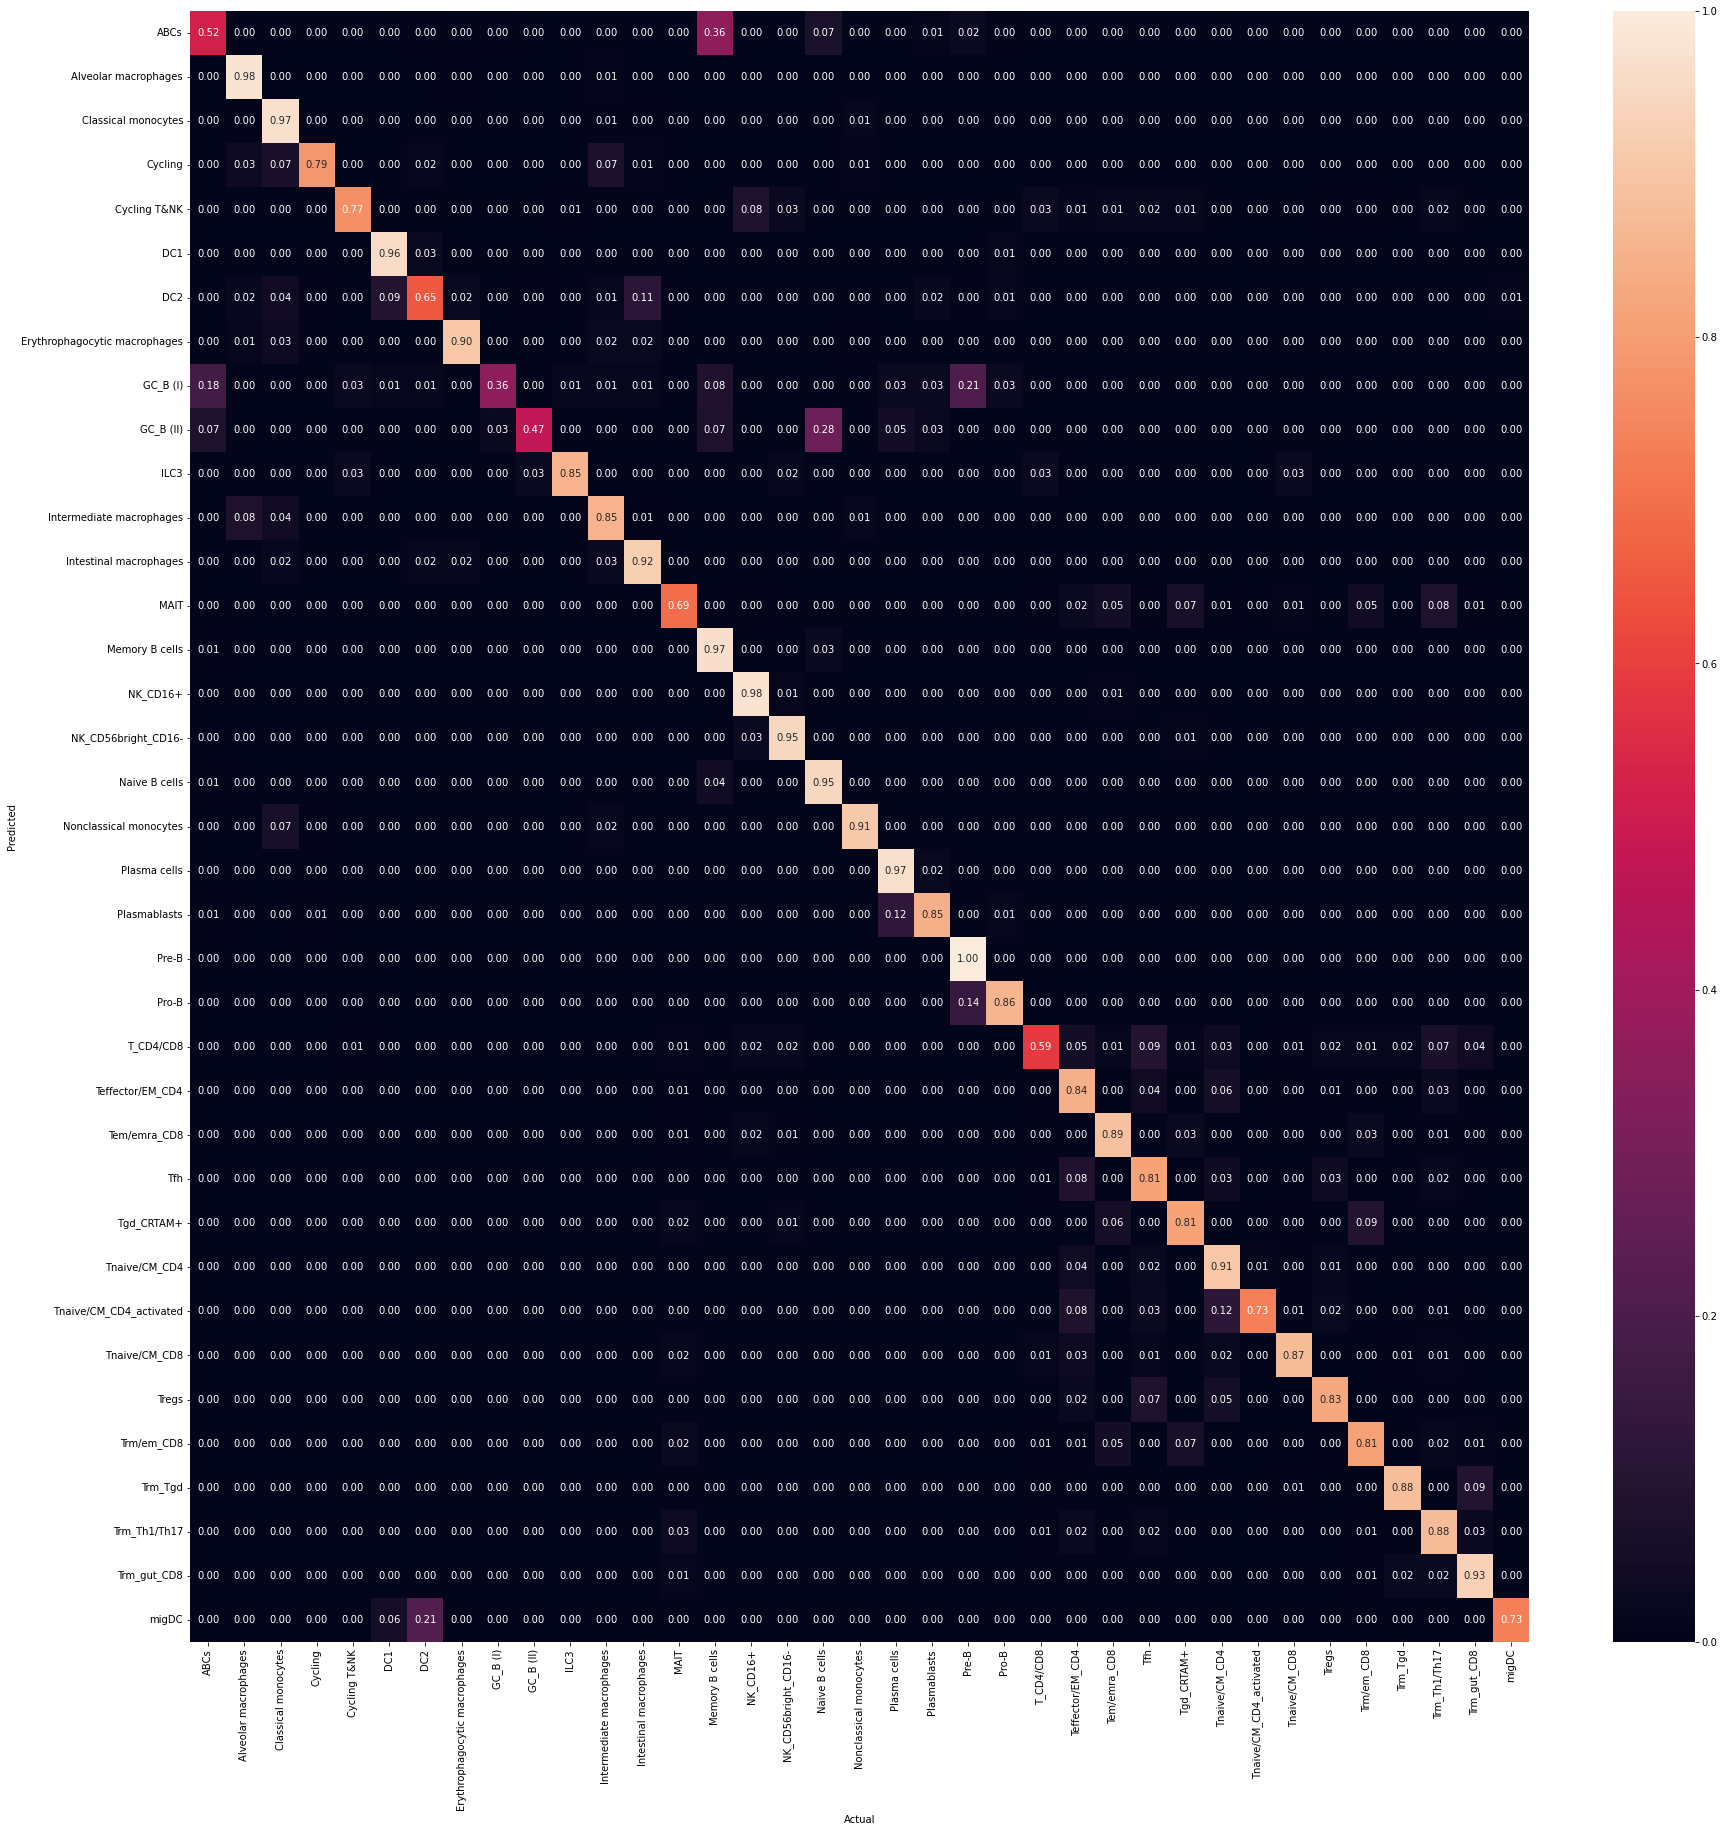

In [12]:
mode='Proto_Net'
loss_mode='disto_pl'
model = train(mode=mode, loss_mode=loss_mode, epochs=50)
plot_confusion_matrix(mode, model)
# torch.save(model.state_dict(), './models/'+mode+'_'+loss_mode+'.pt')

In [24]:
out_popv, embeddings_popv = model(torch.tensor(dataset_popv_pca.X))

In [66]:
# Training
training_out, training_embeddings = model(torch.tensor(dataset_celltypist_pca[train_indices].X))
training_embeddings_true_labels = dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype']
training_embeddings_pred_labels = []
training_embeddings = training_embeddings.detach().cpu().numpy()
training_out = training_out.detach().cpu().numpy()

In [25]:
embedding_prototypes = model.prototypes.detach().cpu().numpy()
embedding_prototypes_labels = encoder_celltype.inverse_transform(range(len(dataset_celltypist_pca.obs['Manually_curated_celltype'].unique().tolist())))

In [26]:
true_labels_popv = dataset_popv_pca.obs['cell_type']
pred_labels_popv = []
embeddings_popv = embeddings_popv.detach().cpu().numpy()
training_out = out_popv.detach().cpu().numpy()
for i in range(len(out_popv)):
    pred_labels_popv.append(encoder_celltype.inverse_transform([out_popv[i].argmax()])[0])

True positive memory b cells: 82.4445011482521%


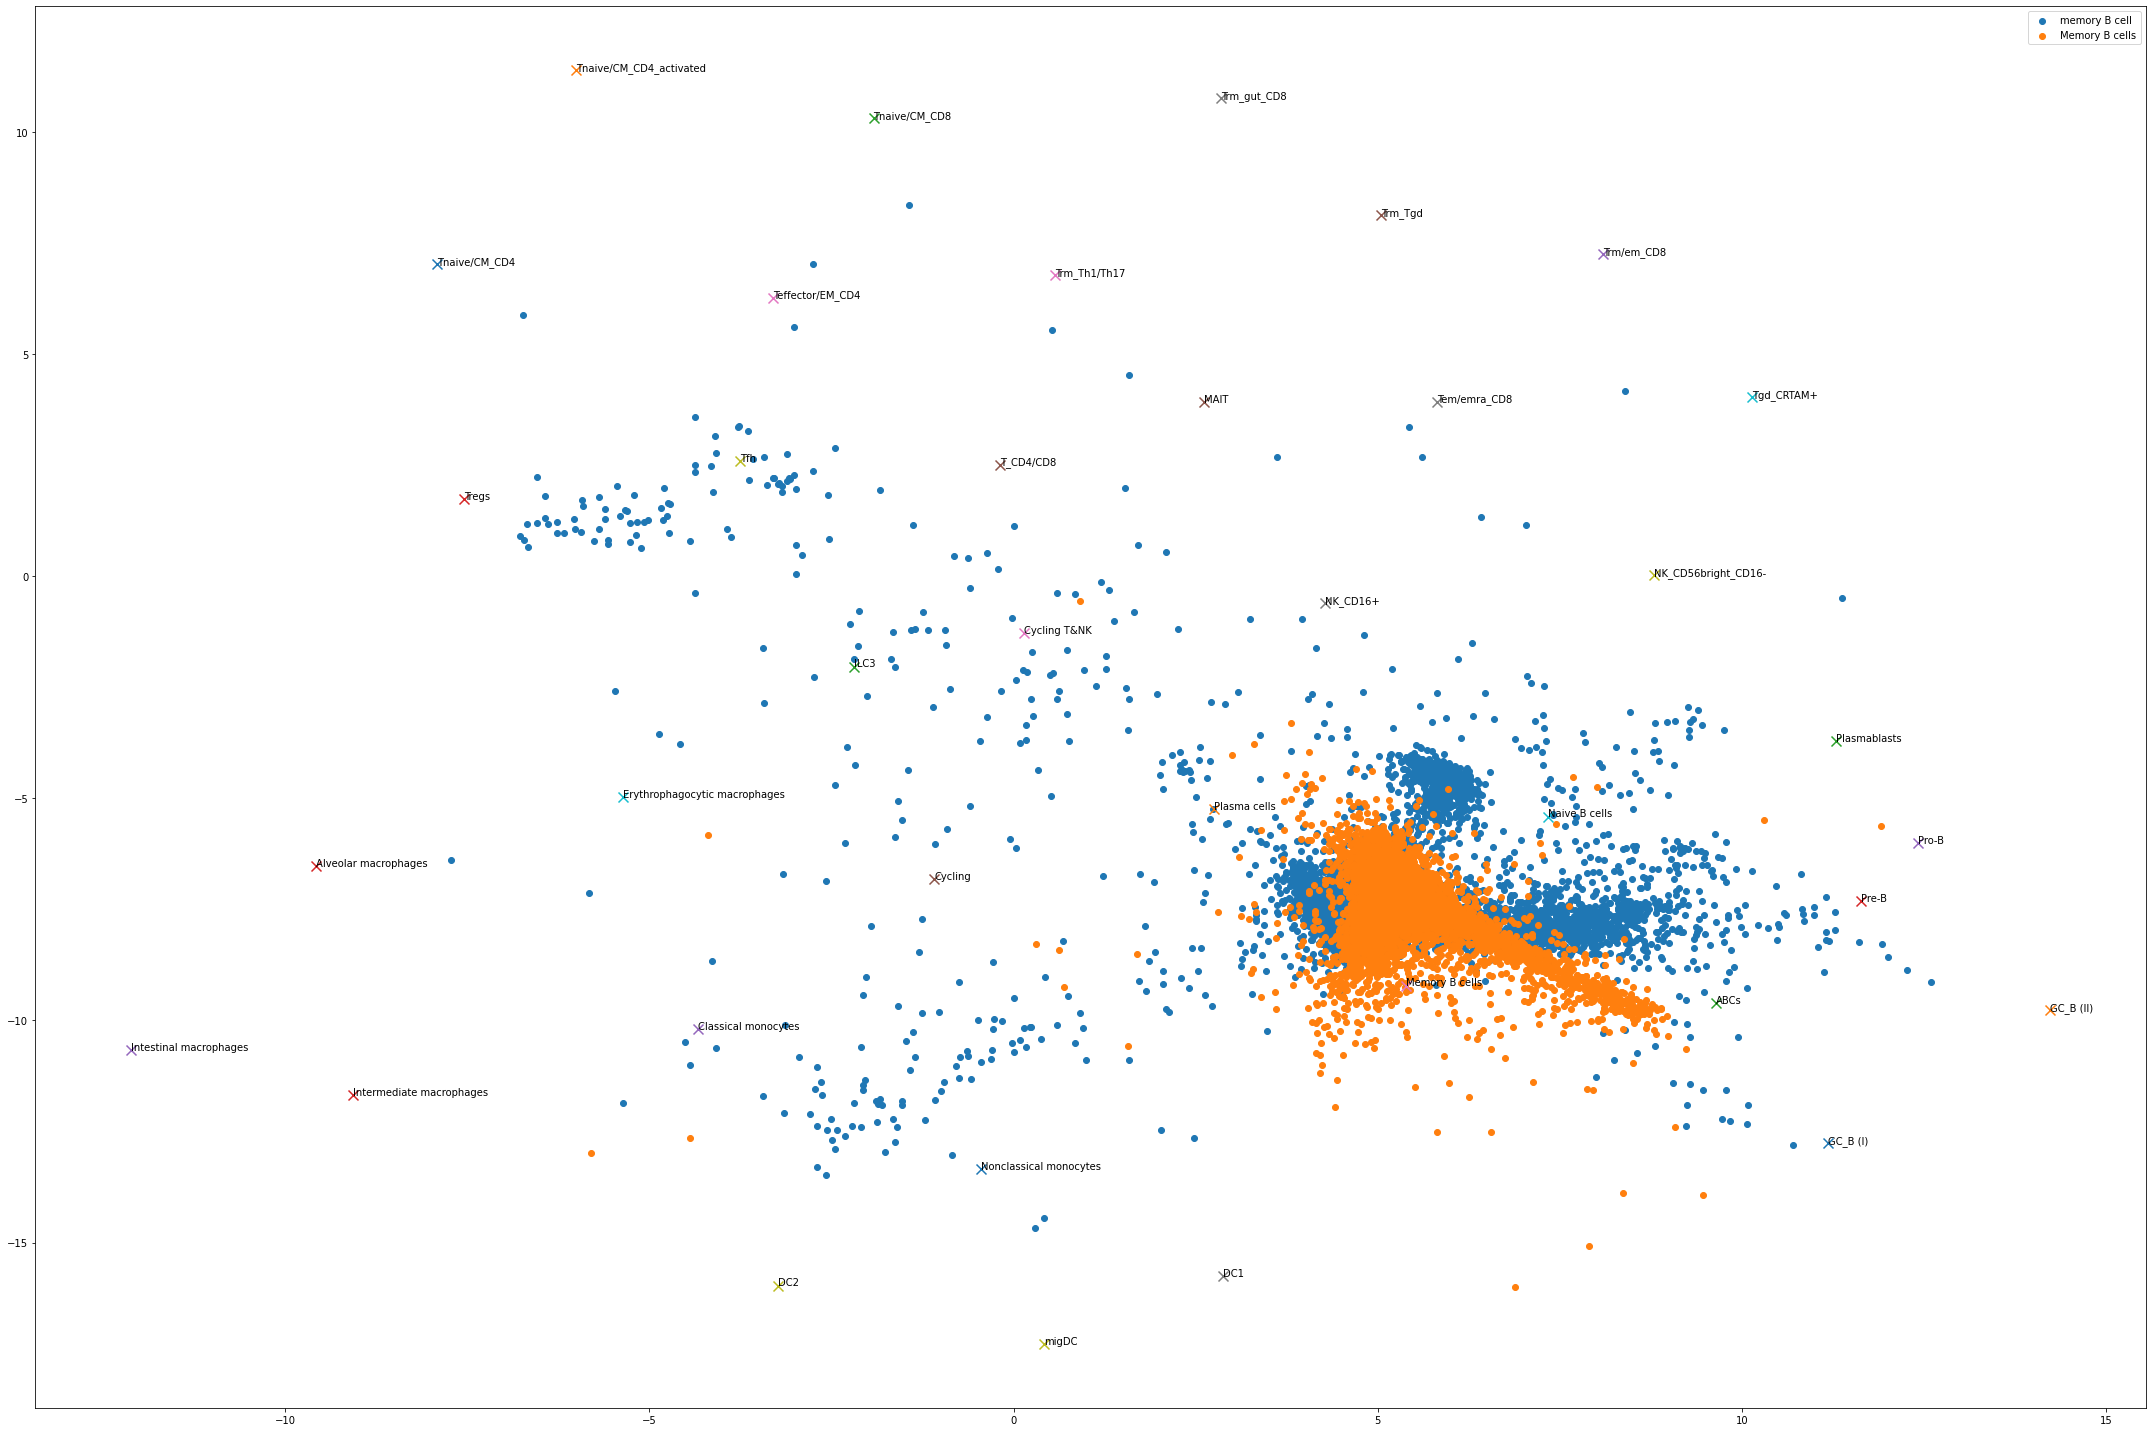

In [73]:
memory_b_cell_count = 0
memory_b_cell_pred = 0
for i in range(len(pred_labels_popv)):
    if true_labels_popv[i] == 'memory B cell':
        memory_b_cell_count += 1
        if pred_labels_popv[i] == 'Memory B cells':
            memory_b_cell_pred += 1
print("True positive memory b cells: " + str(memory_b_cell_pred/memory_b_cell_count * 100) + '%')

fig, ax = plt.subplots(figsize=(30, 20))
for color in np.unique(['memory B cell']):
    i = np.where(np.array(true_labels_popv) == color)
    ax.scatter(np.array(embeddings_popv)[i,0], np.array(embeddings_popv)[i,1], label=color)
for color in np.unique(['Memory B cells']):
    i = np.where(np.array(training_embeddings_true_labels) == color)
    ax.scatter(np.array(training_embeddings)[i,0], np.array(training_embeddings)[i,1], label=color)
for i in range(embedding_prototypes.shape[0]):
    ax.scatter(embedding_prototypes[i,0], embedding_prototypes[i,1], marker='x', s=100)
    ax.annotate(embedding_prototypes_labels[i], (embedding_prototypes[i,0], embedding_prototypes[i,1]))
# ax.scatter(embedding_prototypes[:,0], embedding_prototypes[:,1], marker='x', s=100, label='Prototypes')
ax.legend()
plt.show()

True positive naive b cells: 94.24641325247745%


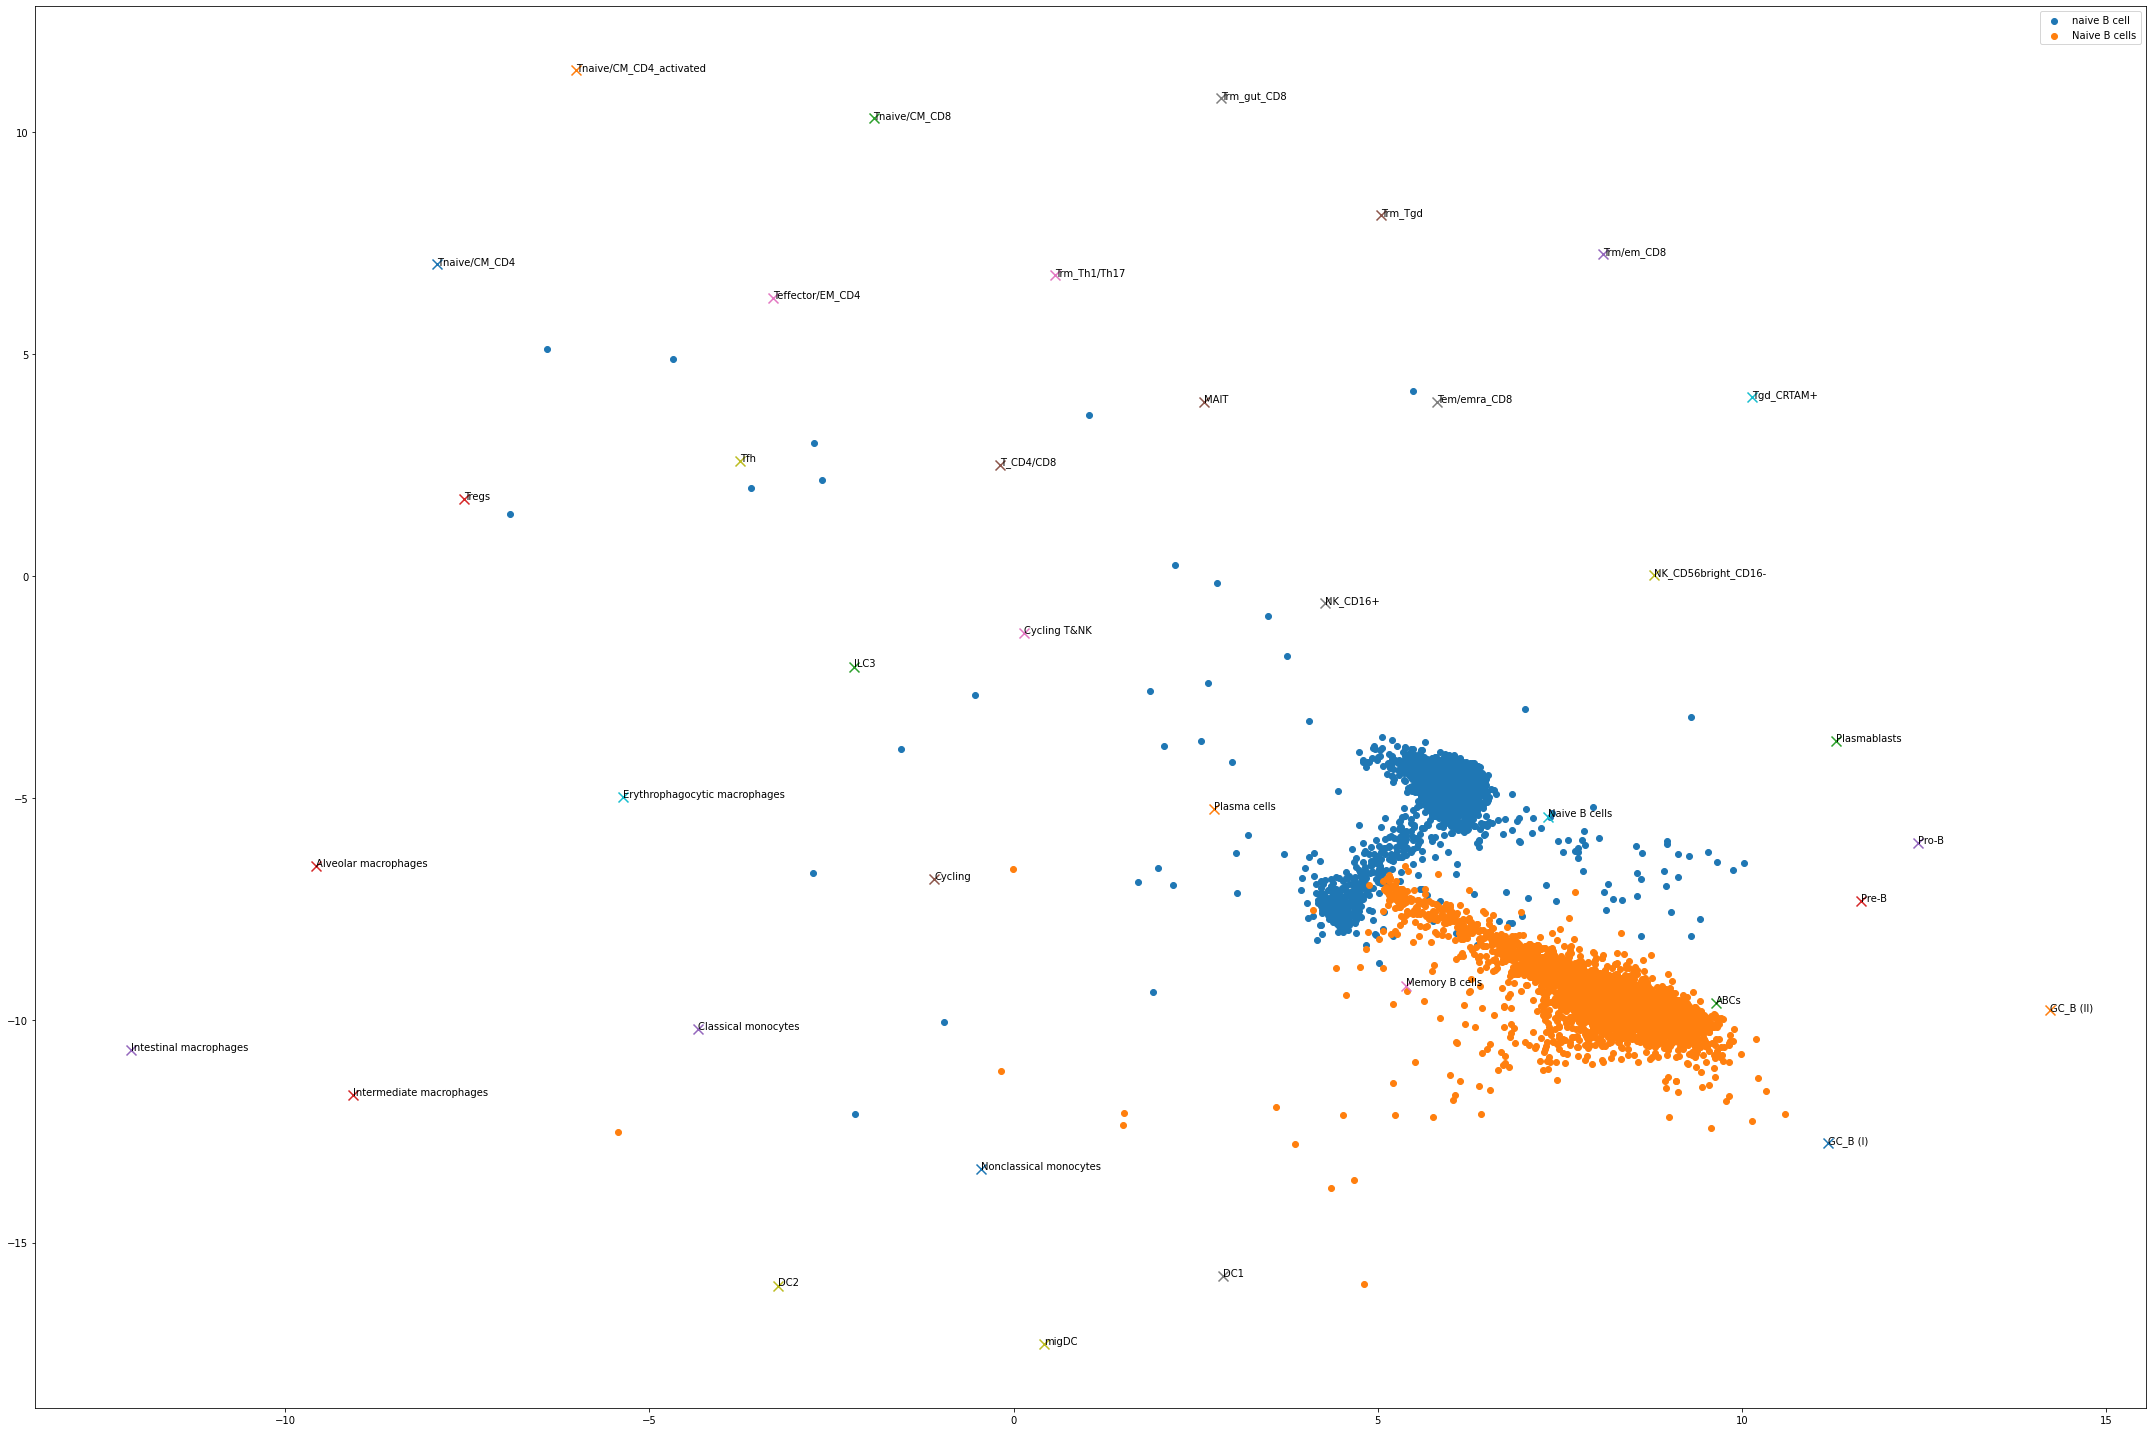

In [76]:
naive_b_cell_count = 0
naive_b_cell_pred = 0
for i in range(len(pred_labels_popv)):
    if true_labels_popv[i] == 'naive B cell':
        naive_b_cell_count += 1
        if pred_labels_popv[i] == 'Naive B cells':
            naive_b_cell_pred += 1
print("True positive naive b cells: " + str(naive_b_cell_pred/naive_b_cell_count * 100) + '%')

fig, ax = plt.subplots(figsize=(30, 20))
for color in np.unique(['naive B cell']):
    i = np.where(np.array(true_labels_popv) == color)
    ax.scatter(np.array(embeddings_popv)[i,0], np.array(embeddings_popv)[i,1], label=color)
for color in np.unique(['Naive B cells']):
    i = np.where(np.array(training_embeddings_true_labels) == color)
    ax.scatter(np.array(training_embeddings)[i,0], np.array(training_embeddings)[i,1], label=color)
for i in range(embedding_prototypes.shape[0]):
    ax.scatter(embedding_prototypes[i,0], embedding_prototypes[i,1], marker='x', s=100)
    ax.annotate(embedding_prototypes_labels[i], (embedding_prototypes[i,0], embedding_prototypes[i,1]))
# ax.scatter(embedding_prototypes[:,0], embedding_prototypes[:,1], marker='x', s=100, label='Prototypes')
ax.legend()
plt.show()

True positive T follicular helper cell: 39.44723618090452%


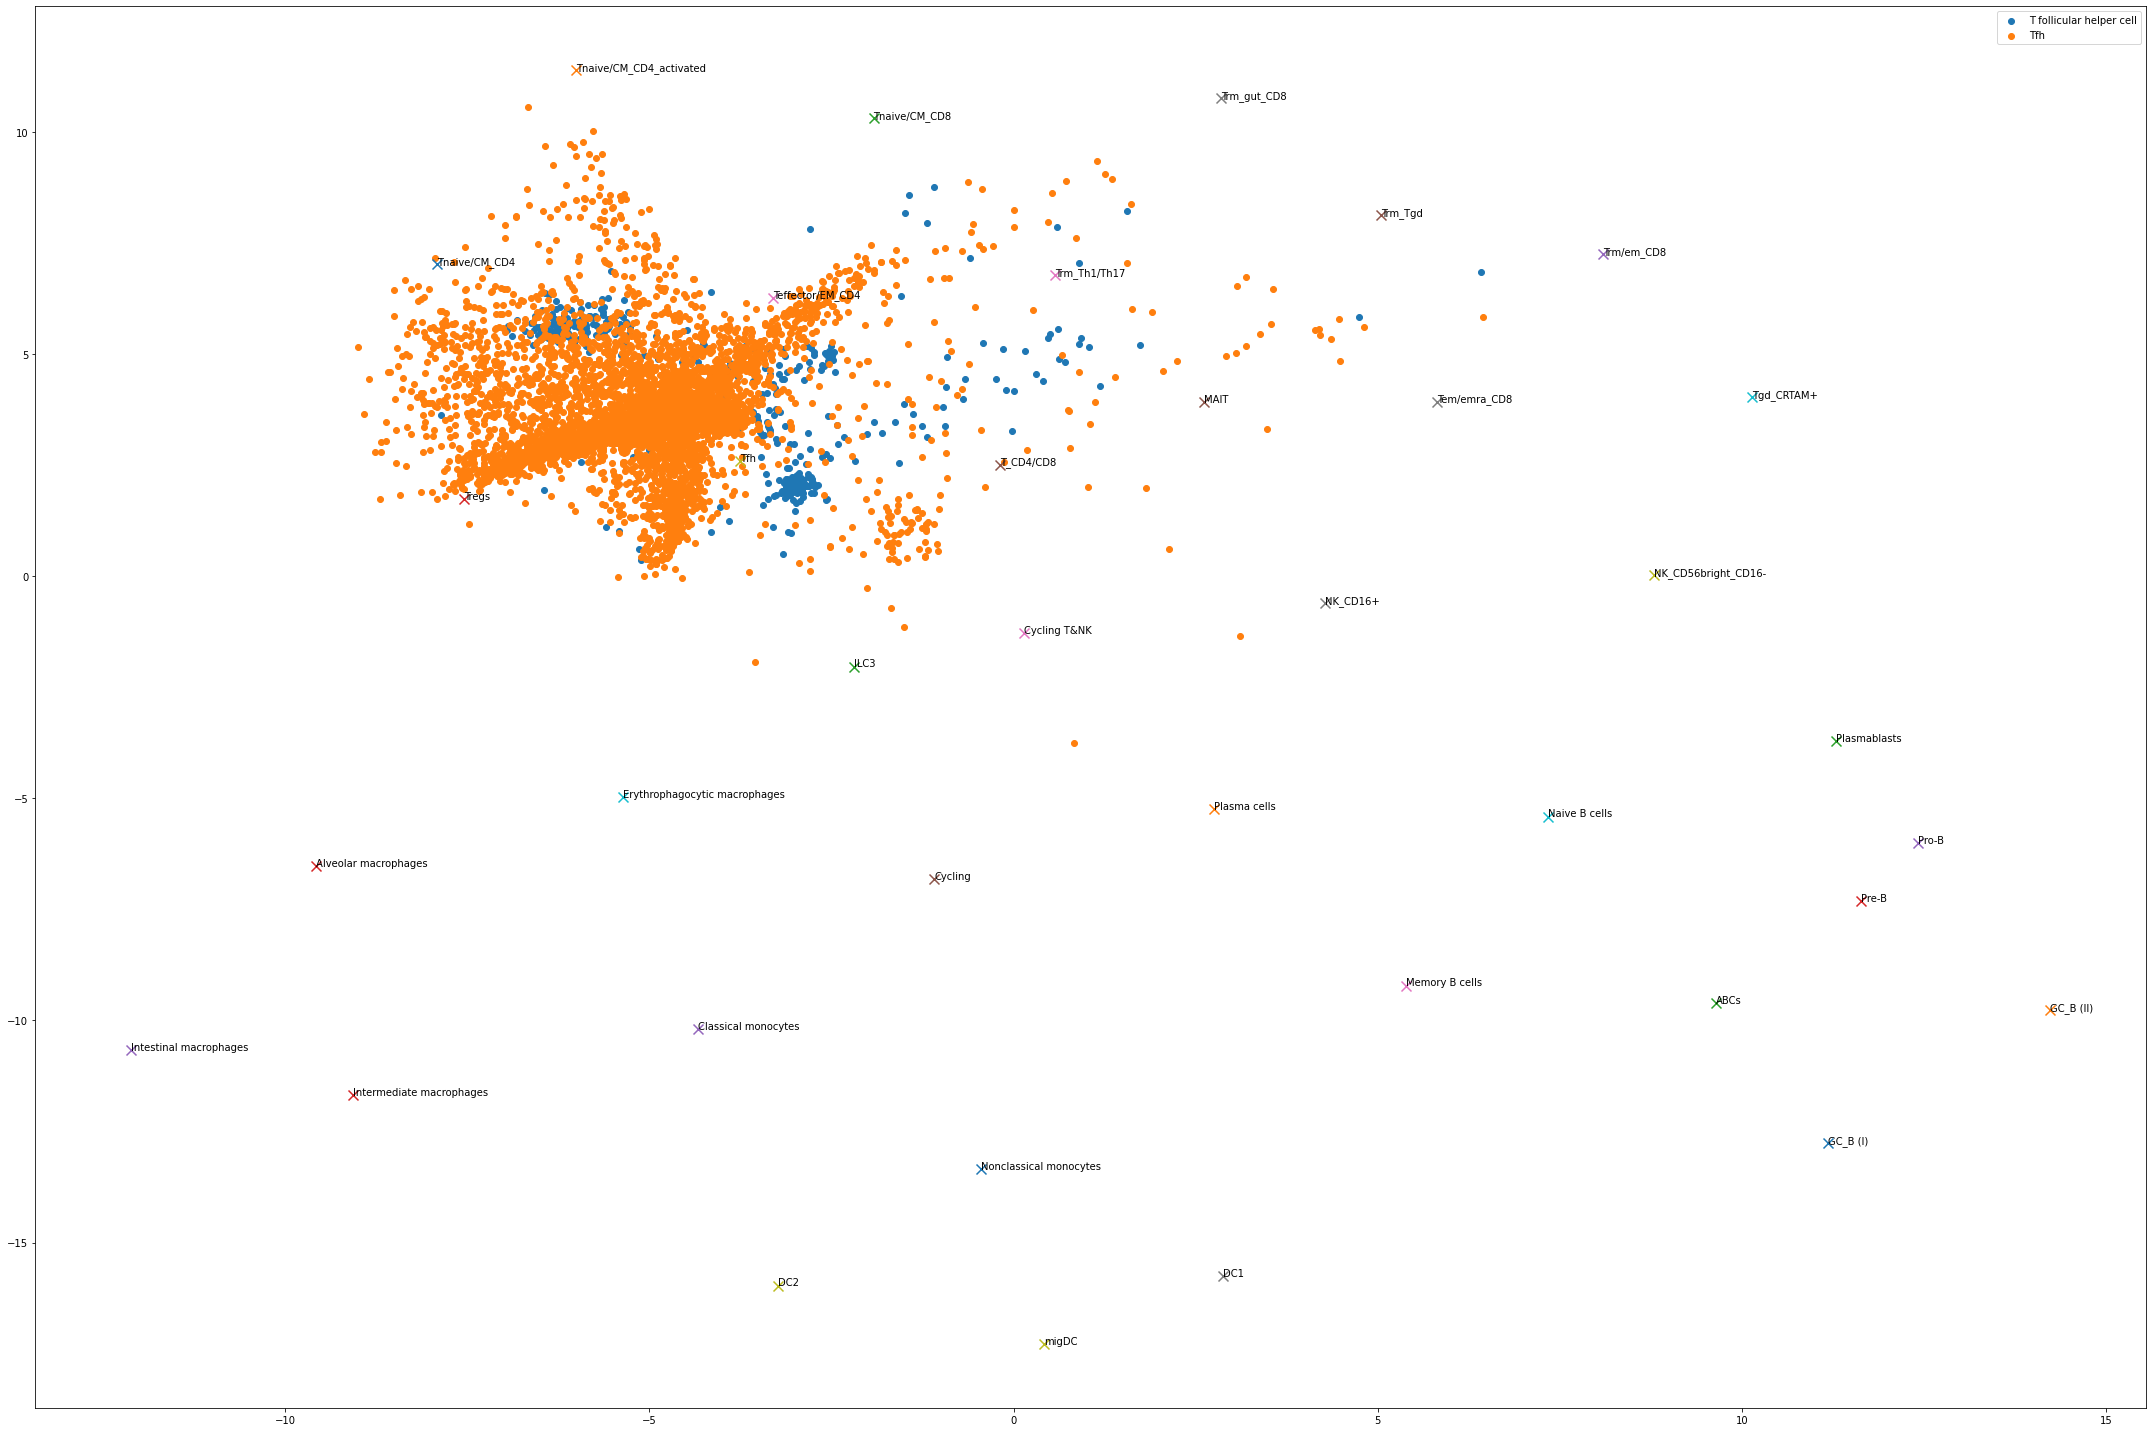

{'Teffector/EM_CD4': 95, 'Tnaive/CM_CD4': 98, 'T_CD4/CD8': 19, 'Tnaive/CM_CD8': 3, 'Trm_Th1/Th17': 17, 'Tregs': 5, 'Trm/em_CD8': 1, 'MAIT': 2, 'Tem/emra_CD8': 1}


In [83]:
tfh_cell_count = 0
tfh_cell_pred = 0
for i in range(len(pred_labels_popv)):
    if true_labels_popv[i] == 'T follicular helper cell':
        tfh_cell_count += 1
        if pred_labels_popv[i] == 'Tfh':
            tfh_cell_pred += 1
print("True positive T follicular helper cell: " + str(tfh_cell_pred/tfh_cell_count * 100) + '%')

fig, ax = plt.subplots(figsize=(30, 20))
for color in np.unique(['T follicular helper cell']):
    i = np.where(np.array(true_labels_popv) == color)
    ax.scatter(np.array(embeddings_popv)[i,0], np.array(embeddings_popv)[i,1], label=color)
for color in np.unique(['Tfh']):
    i = np.where(np.array(training_embeddings_true_labels) == color)
    ax.scatter(np.array(training_embeddings)[i,0], np.array(training_embeddings)[i,1], label=color)
for i in range(embedding_prototypes.shape[0]):
    ax.scatter(embedding_prototypes[i,0], embedding_prototypes[i,1], marker='x', s=100)
    ax.annotate(embedding_prototypes_labels[i], (embedding_prototypes[i,0], embedding_prototypes[i,1]))
# ax.scatter(embedding_prototypes[:,0], embedding_prototypes[:,1], marker='x', s=100, label='Prototypes')
ax.legend()
plt.show()
tfh_fn = []
tfh_fn_dict = {}
for i in range(len(pred_labels_popv)):
    if true_labels_popv[i] == 'T follicular helper cell' and pred_labels_popv[i] != 'Tfh':
        tfh_fn.append(pred_labels_popv[i])
        if pred_labels_popv[i] in tfh_fn_dict.keys():
            tfh_fn_dict[pred_labels_popv[i]] += 1
        else:
            tfh_fn_dict[pred_labels_popv[i]] = 1
print(tfh_fn_dict)

True positive plasma cell: 59.40233867475098%


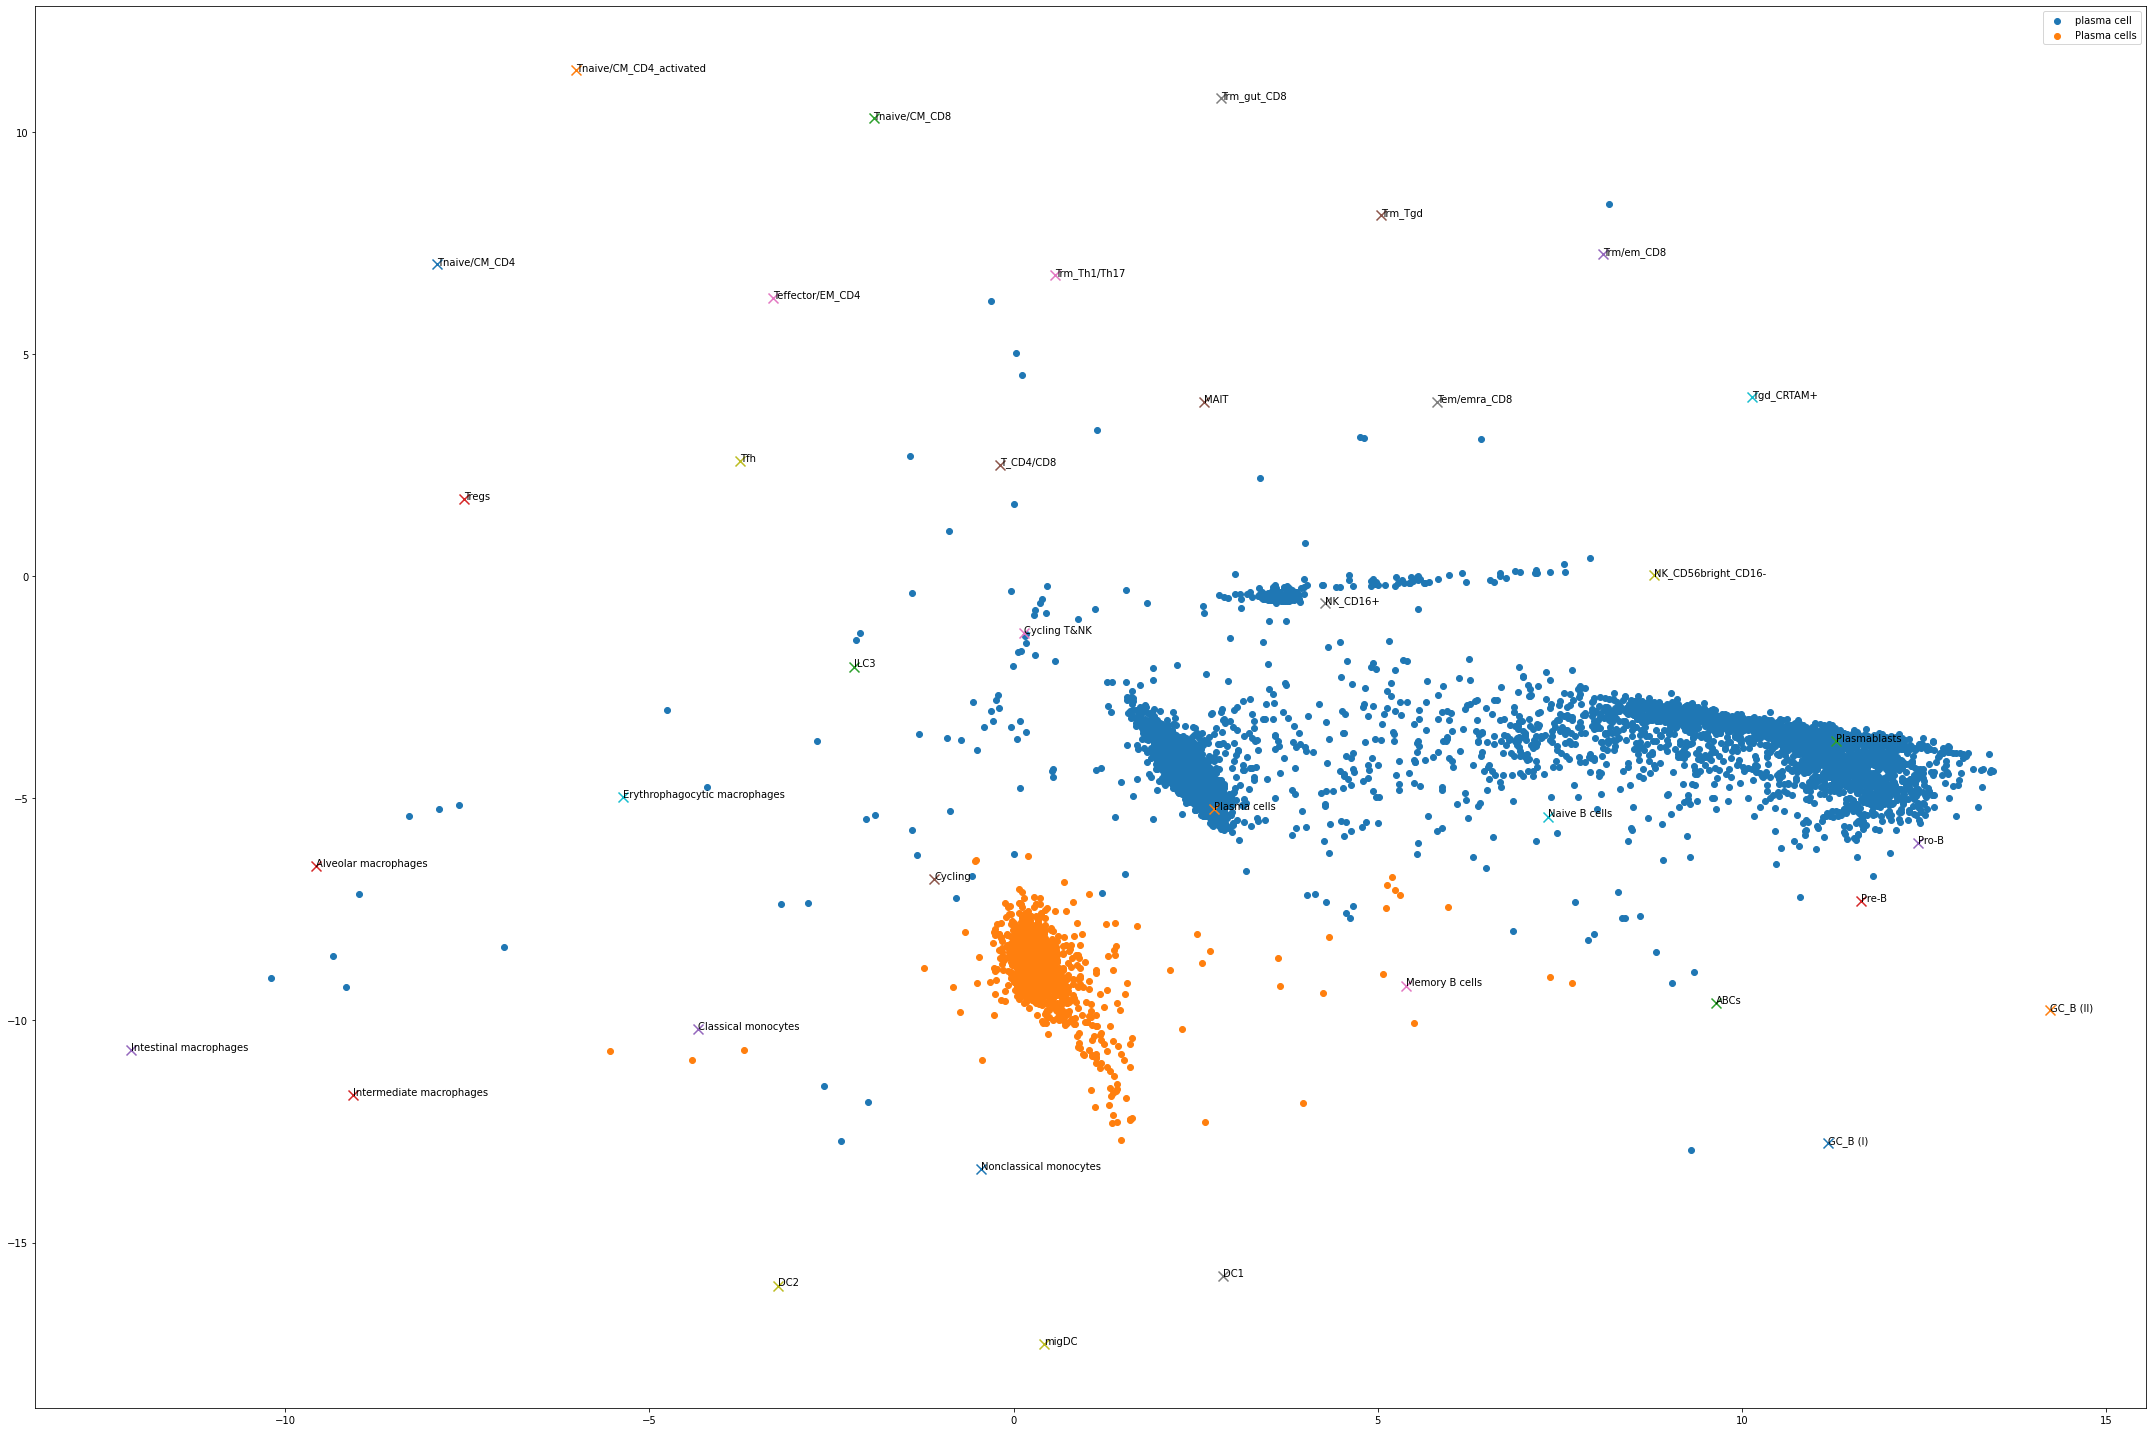

{'Teffector/EM_CD4': 95, 'Tnaive/CM_CD4': 98, 'T_CD4/CD8': 19, 'Tnaive/CM_CD8': 3, 'Trm_Th1/Th17': 17, 'Tregs': 5, 'Trm/em_CD8': 1, 'MAIT': 2, 'Tem/emra_CD8': 1}


In [85]:
plasma_cell_count = 0
plasma_cell_pred = 0
for i in range(len(pred_labels_popv)):
    if true_labels_popv[i] == 'plasma cell':
        plasma_cell_count += 1
        if pred_labels_popv[i] == 'Plasma cells':
            plasma_cell_pred += 1
print("True positive plasma cell: " + str(plasma_cell_pred/plasma_cell_count * 100) + '%')

fig, ax = plt.subplots(figsize=(30, 20))
for color in np.unique(['plasma cell']):
    i = np.where(np.array(true_labels_popv) == color)
    ax.scatter(np.array(embeddings_popv)[i,0], np.array(embeddings_popv)[i,1], label=color)
for color in np.unique(['Plasma cells']):
    i = np.where(np.array(training_embeddings_true_labels) == color)
    ax.scatter(np.array(training_embeddings)[i,0], np.array(training_embeddings)[i,1], label=color)
for i in range(embedding_prototypes.shape[0]):
    ax.scatter(embedding_prototypes[i,0], embedding_prototypes[i,1], marker='x', s=100)
    ax.annotate(embedding_prototypes_labels[i], (embedding_prototypes[i,0], embedding_prototypes[i,1]))
# ax.scatter(embedding_prototypes[:,0], embedding_prototypes[:,1], marker='x', s=100, label='Prototypes')
ax.legend()
plt.show()
plasma_cell_fn = []
plasma_cell_fn_dict = {}
for i in range(len(pred_labels_popv)):
    if true_labels_popv[i] == 'plasma cell' and pred_labels_popv[i] != 'Plasma cells':
        plasma_cell_fn.append(pred_labels_popv[i])
        if pred_labels_popv[i] in plasma_cell_fn_dict.keys():
            plasma_cell_fn_dict[pred_labels_popv[i]] += 1
        else:
            plasma_cell_fn_dict[pred_labels_popv[i]] = 1
print(tfh_fn_dict)

True positive Regulatory T cells: 100.0%


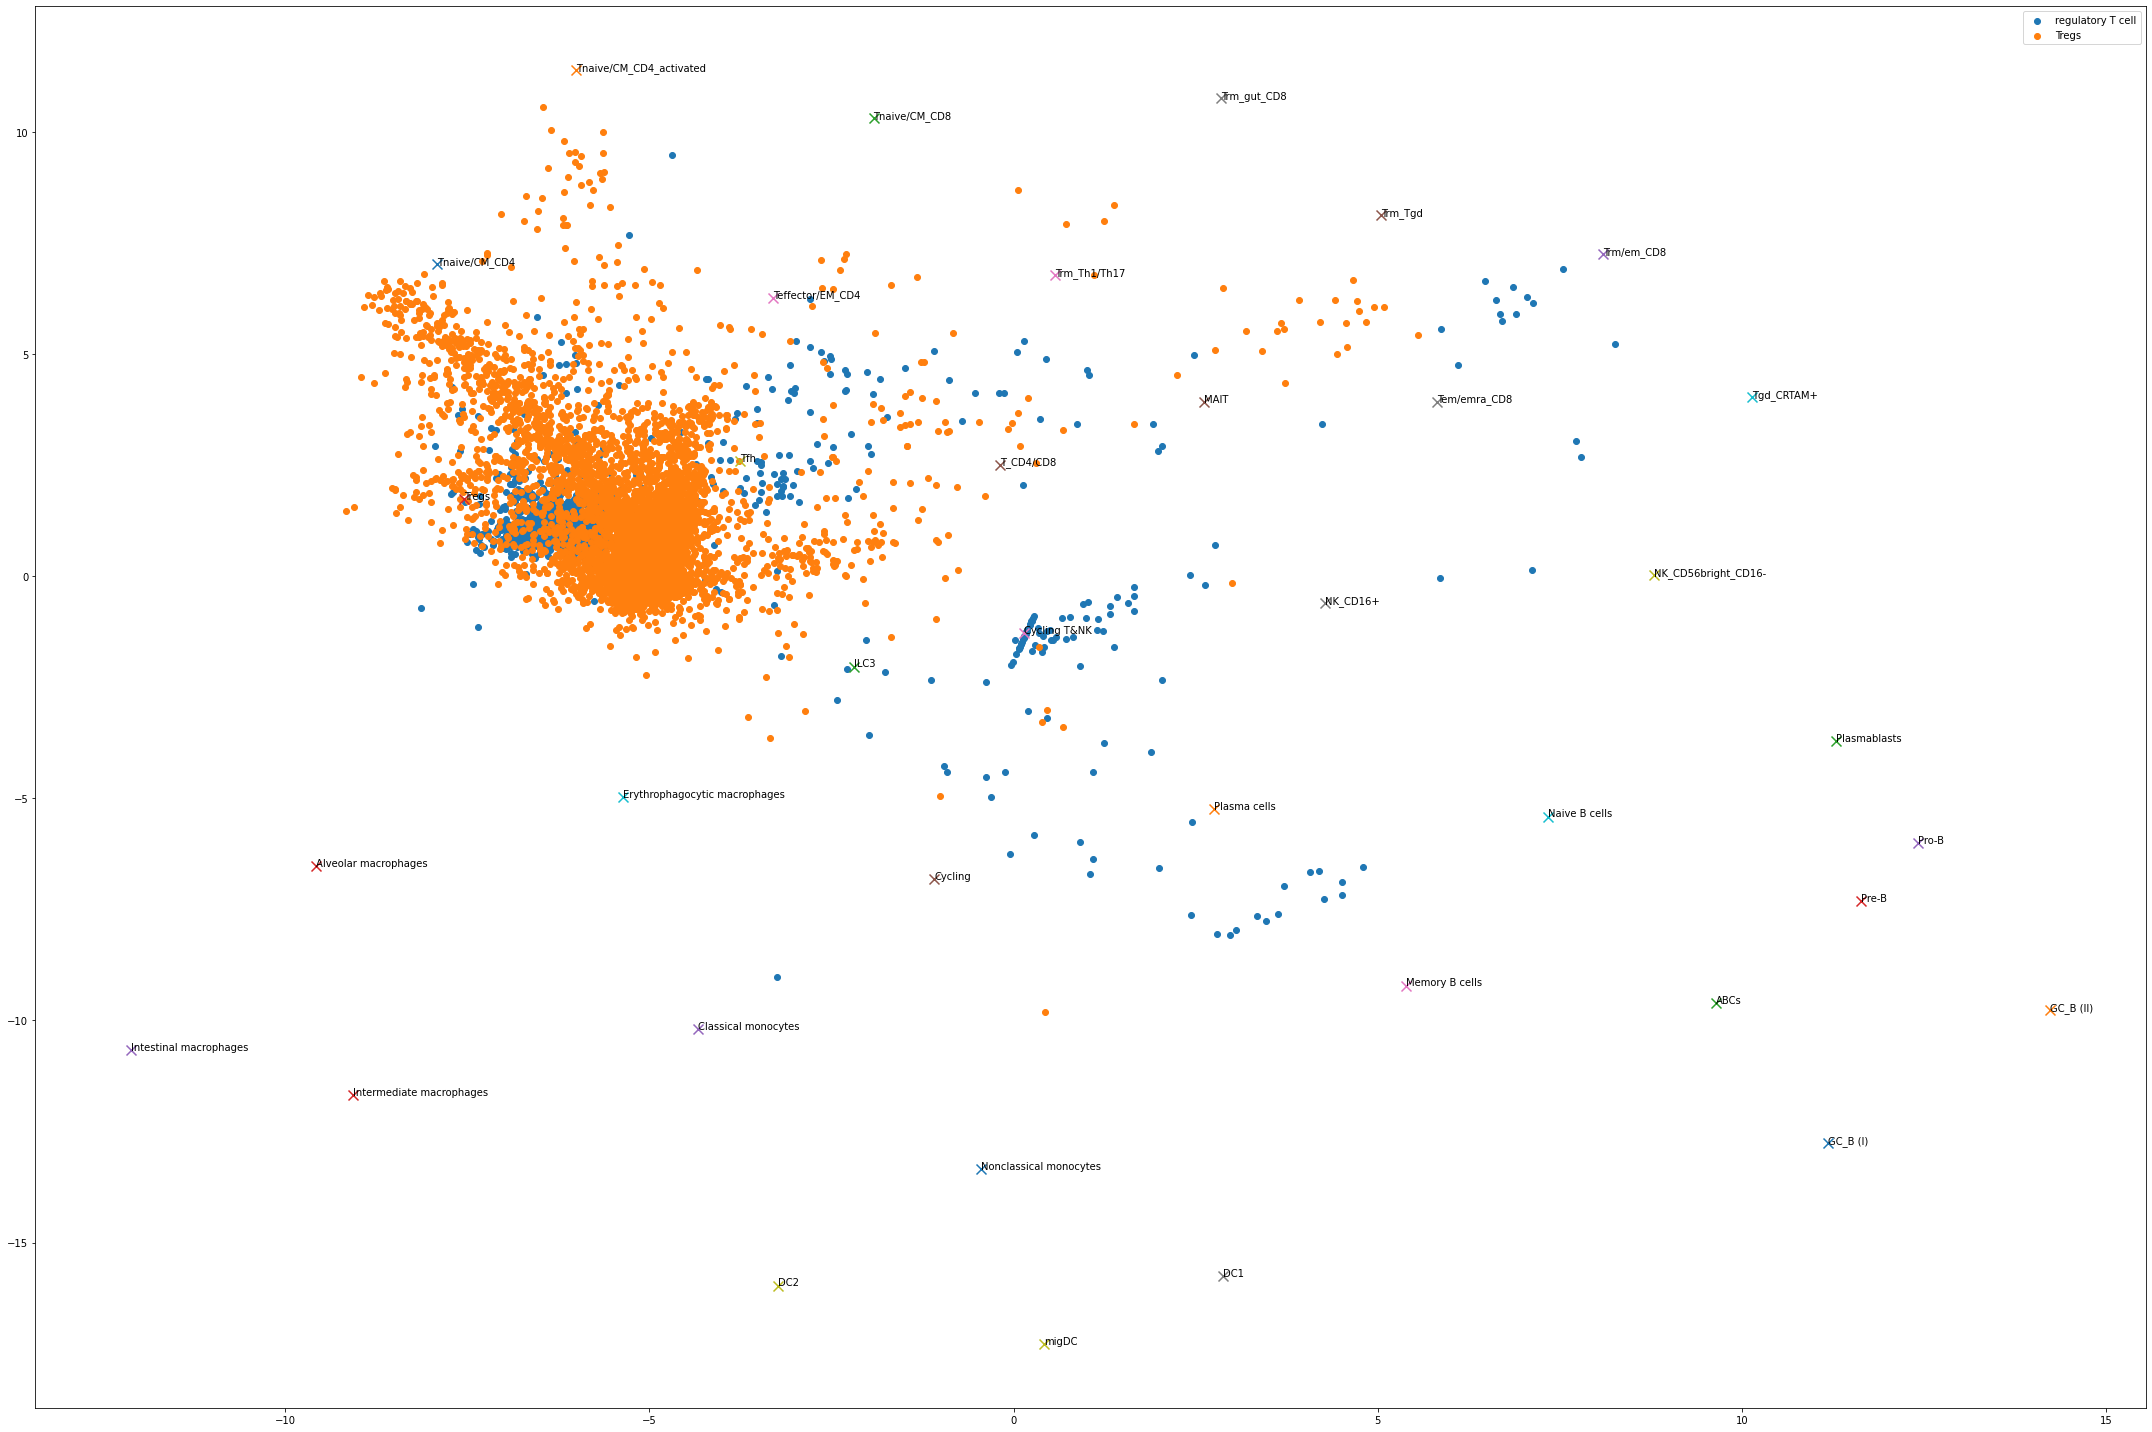

{'Tregs': 1015, 'Plasma cells': 15, 'Tnaive/CM_CD4_activated': 1, 'Tfh': 119, 'Memory B cells': 6, 'Tnaive/CM_CD4': 7, 'Cycling': 7, 'Cycling T&NK': 63, 'Teffector/EM_CD4': 16, 'Trm/em_CD8': 9, 'Trm_Th1/Th17': 4, 'ILC3': 12, 'MAIT': 6, 'Tem/emra_CD8': 6, 'T_CD4/CD8': 11, 'NK_CD16+': 4, 'Classical monocytes': 1, 'NK_CD56bright_CD16-': 1}


In [86]:
treg_cell_count = 0
treg_cell_pred = 0
for i in range(len(pred_labels_popv)):
    if true_labels_popv[i] == 'regulatory T cell':
        treg_cell_count += 1
        if pred_labels_popv[i] == 'Tregs':
            treg_cell_pred += 1
print("True positive Regulatory T cells: " + str(treg_cell_count/treg_cell_count * 100) + '%')

fig, ax = plt.subplots(figsize=(30, 20))
for color in np.unique(['regulatory T cell']):
    i = np.where(np.array(true_labels_popv) == color)
    ax.scatter(np.array(embeddings_popv)[i,0], np.array(embeddings_popv)[i,1], label=color)
for color in np.unique(['Tregs']):
    i = np.where(np.array(training_embeddings_true_labels) == color)
    ax.scatter(np.array(training_embeddings)[i,0], np.array(training_embeddings)[i,1], label=color)
for i in range(embedding_prototypes.shape[0]):
    ax.scatter(embedding_prototypes[i,0], embedding_prototypes[i,1], marker='x', s=100)
    ax.annotate(embedding_prototypes_labels[i], (embedding_prototypes[i,0], embedding_prototypes[i,1]))
# ax.scatter(embedding_prototypes[:,0], embedding_prototypes[:,1], marker='x', s=100, label='Prototypes')
ax.legend()
plt.show()
treg_fn = []
treg_fn_dict = {}
for i in range(len(pred_labels_popv)):
    if true_labels_popv[i] == 'regulatory T cell' and pred_labels_popv[i] != 'Trgs':
        treg_fn.append(pred_labels_popv[i])
        if pred_labels_popv[i] in treg_fn_dict.keys():
            treg_fn_dict[pred_labels_popv[i]] += 1
        else:
            treg_fn_dict[pred_labels_popv[i]] = 1
print(treg_fn_dict)

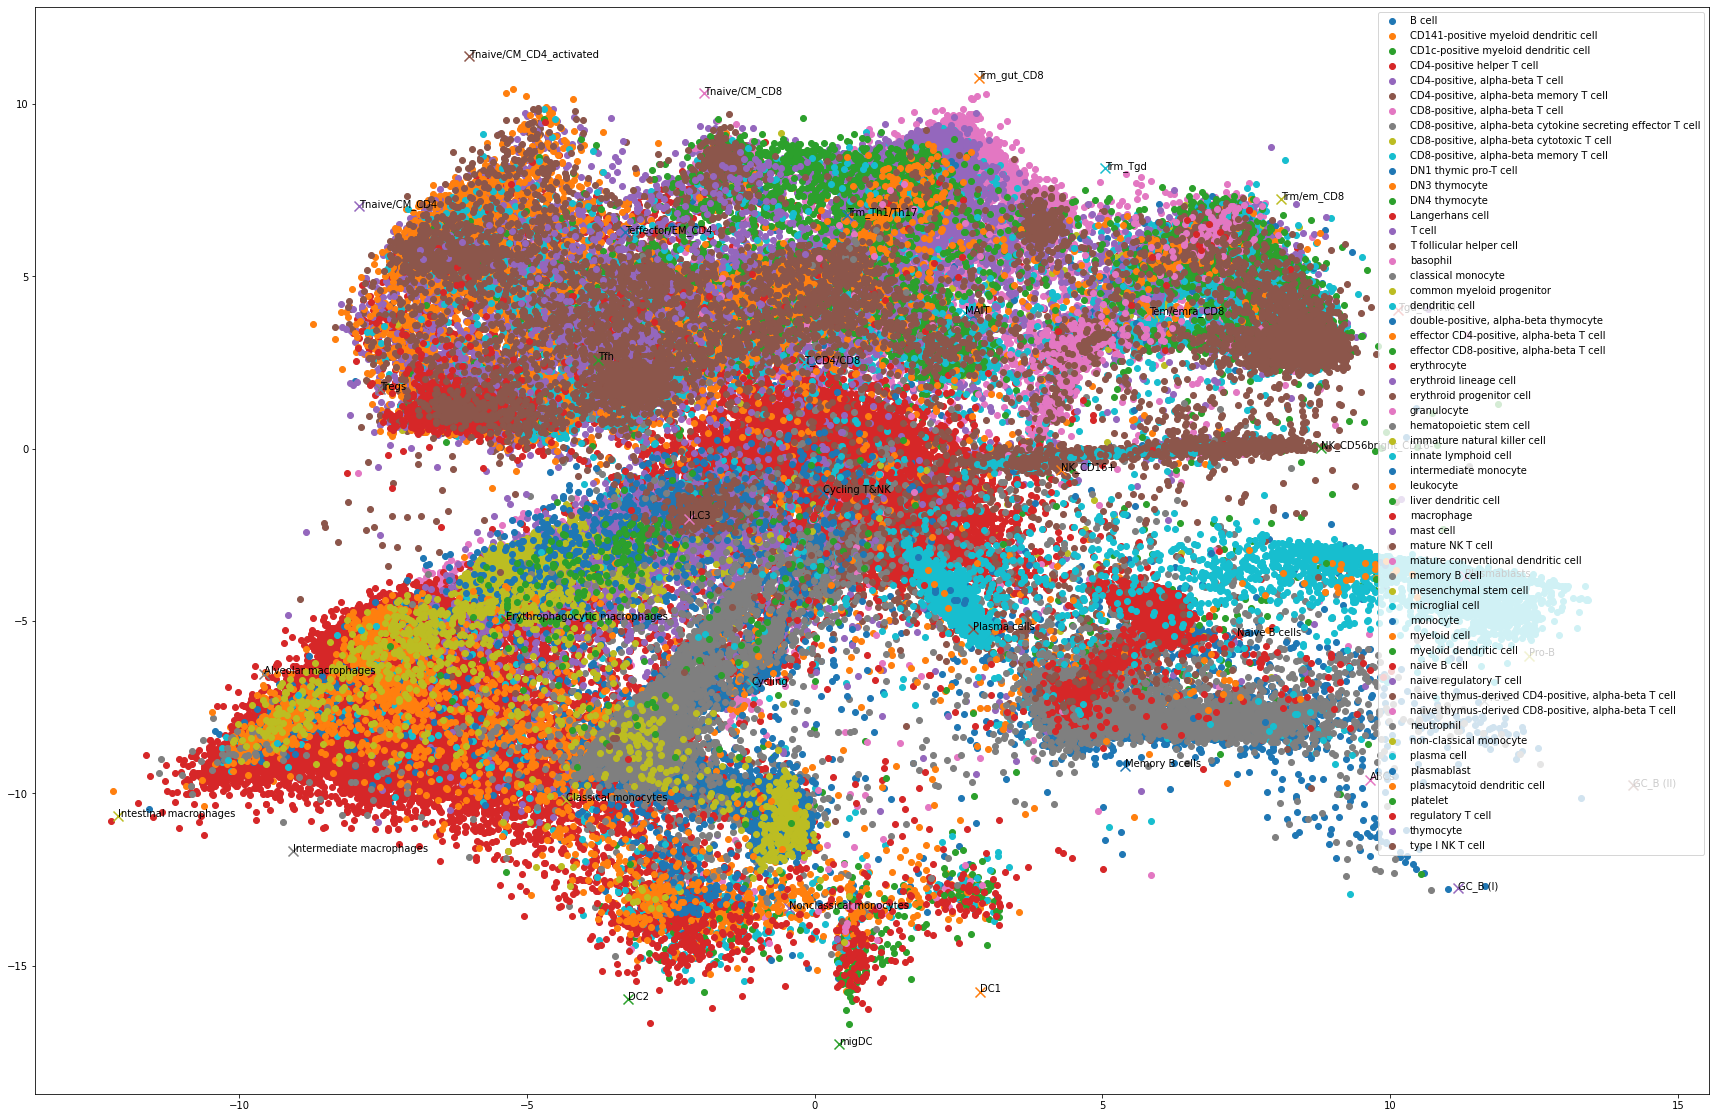

In [30]:
fig, ax = plt.subplots(figsize=(30, 20))
for color in np.unique(np.array(true_labels_popv)):
    i = np.where(np.array(true_labels_popv) == color)
    ax.scatter(np.array(embeddings_popv)[i,0], np.array(embeddings_popv)[i,1], label=color)
for i in range(embedding_prototypes.shape[0]):
    ax.scatter(embedding_prototypes[i,0], embedding_prototypes[i,1], marker='x', s=100)
    ax.annotate(embedding_prototypes_labels[i], (embedding_prototypes[i,0], embedding_prototypes[i,1]))
# ax.scatter(embedding_prototypes[:,0], embedding_prototypes[:,1], marker='x', s=100, label='Prototypes')
ax.legend()
plt.show()

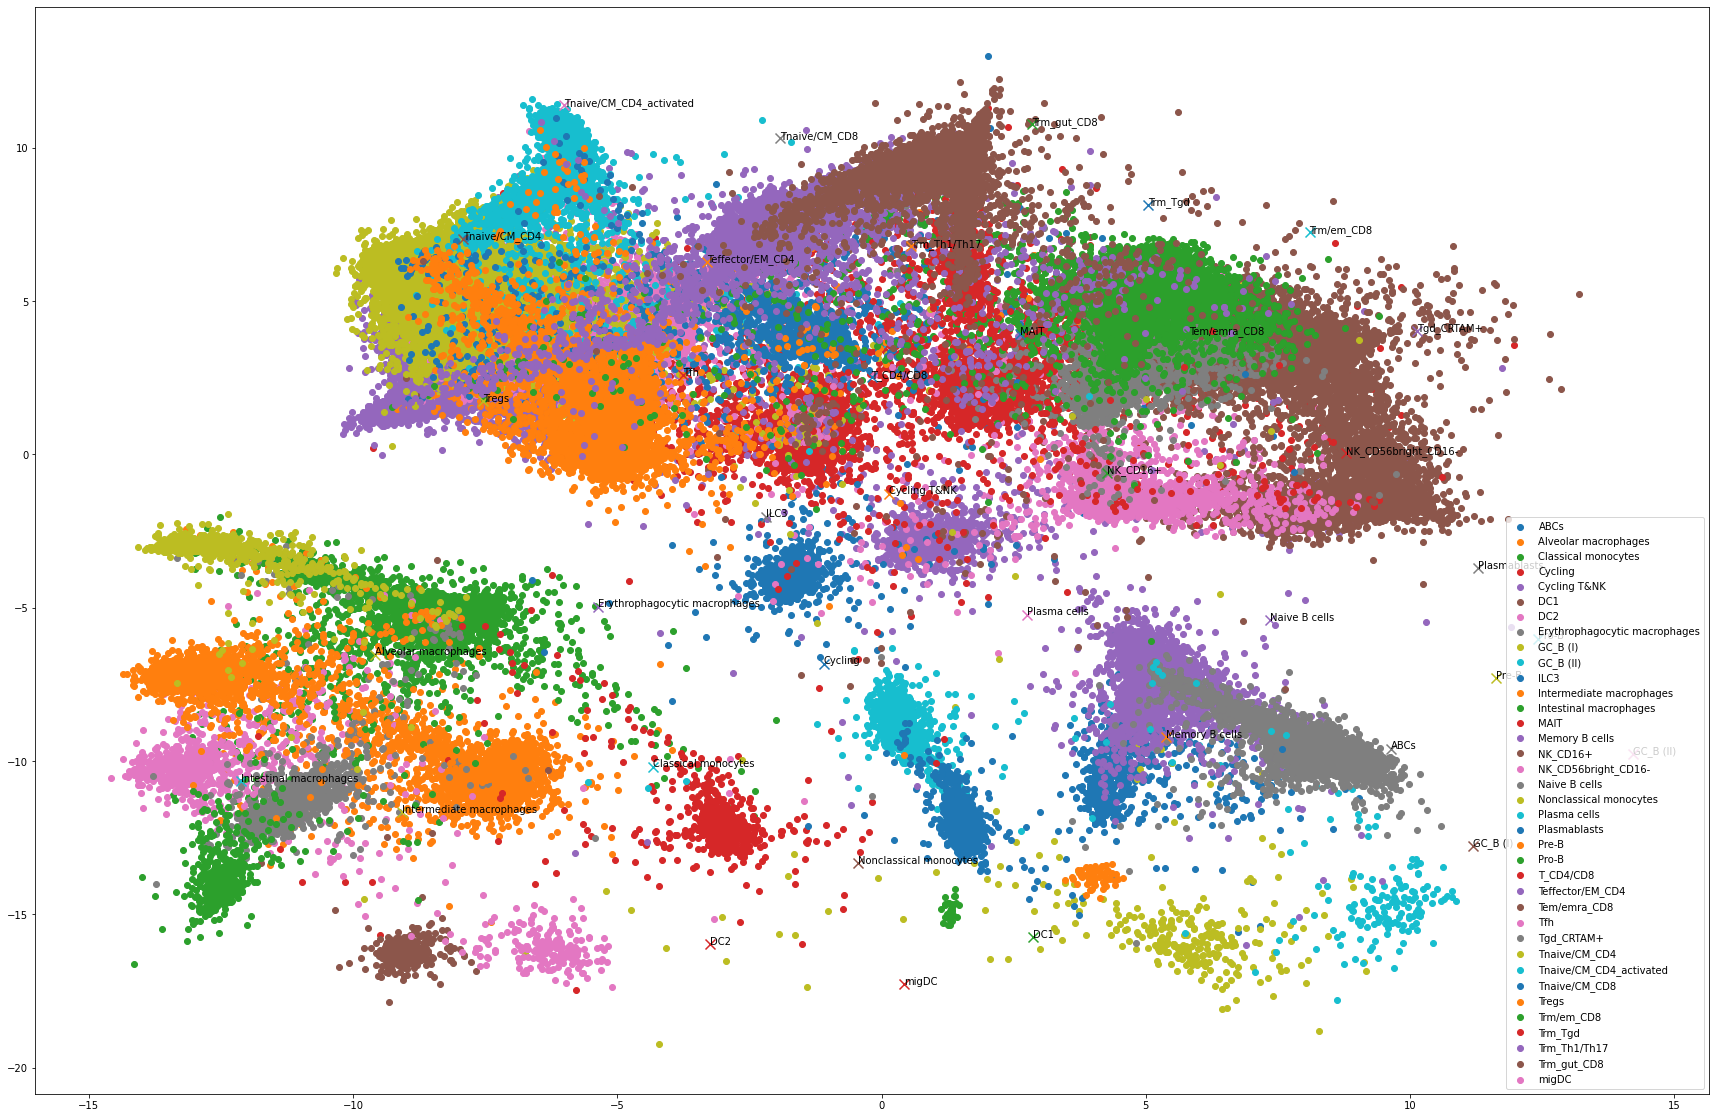

In [29]:
for i in range(len(training_out)):
    training_embeddings_pred_labels.append(encoder_celltype.inverse_transform([training_out[i].argmax()])[0])
fig, ax = plt.subplots(figsize=(30, 20))
for color in np.unique(np.array(training_embeddings_true_labels)):
    i = np.where(np.array(training_embeddings_true_labels) == color)
    ax.scatter(np.array(training_embeddings)[i,0], np.array(training_embeddings)[i,1], label=color)
for i in range(embedding_prototypes.shape[0]):
    ax.scatter(embedding_prototypes[i,0], embedding_prototypes[i,1], marker='x', s=100)
    ax.annotate(embedding_prototypes_labels[i], (embedding_prototypes[i,0], embedding_prototypes[i,1]))
# ax.scatter(embedding_prototypes[:,0], embedding_prototypes[:,1], marker='x', s=100, label='Prototypes')
ax.legend()
plt.show()

In [57]:
# testing
testing_out, testing_embeddings = model(torch.tensor(dataset_celltypist_pca[test_indices].X))
testing_embeddings_true_labels = dataset_celltypist_pca[test_indices].obs['Manually_curated_celltype']
testing_embeddings_pred_labels = []
testing_embeddings = testing_embeddings.detach().cpu().numpy()
testing_out = testing_out.detach().cpu().numpy()
for i in range(len(testing_out)):
    testing_embeddings_pred_labels.append(encoder_celltype.inverse_transform([testing_out[i].argmax()])[0])

In [58]:
training_embeddings_pred_labels_int = encoder_celltype.transform(training_embeddings_pred_labels)
training_embeddings_true_labels_int = encoder_celltype.transform(training_embeddings_true_labels)
testing_embeddings_pred_labels_int = encoder_celltype.transform(testing_embeddings_pred_labels)
testing_embeddings_true_labels_int = encoder_celltype.transform(testing_embeddings_true_labels)

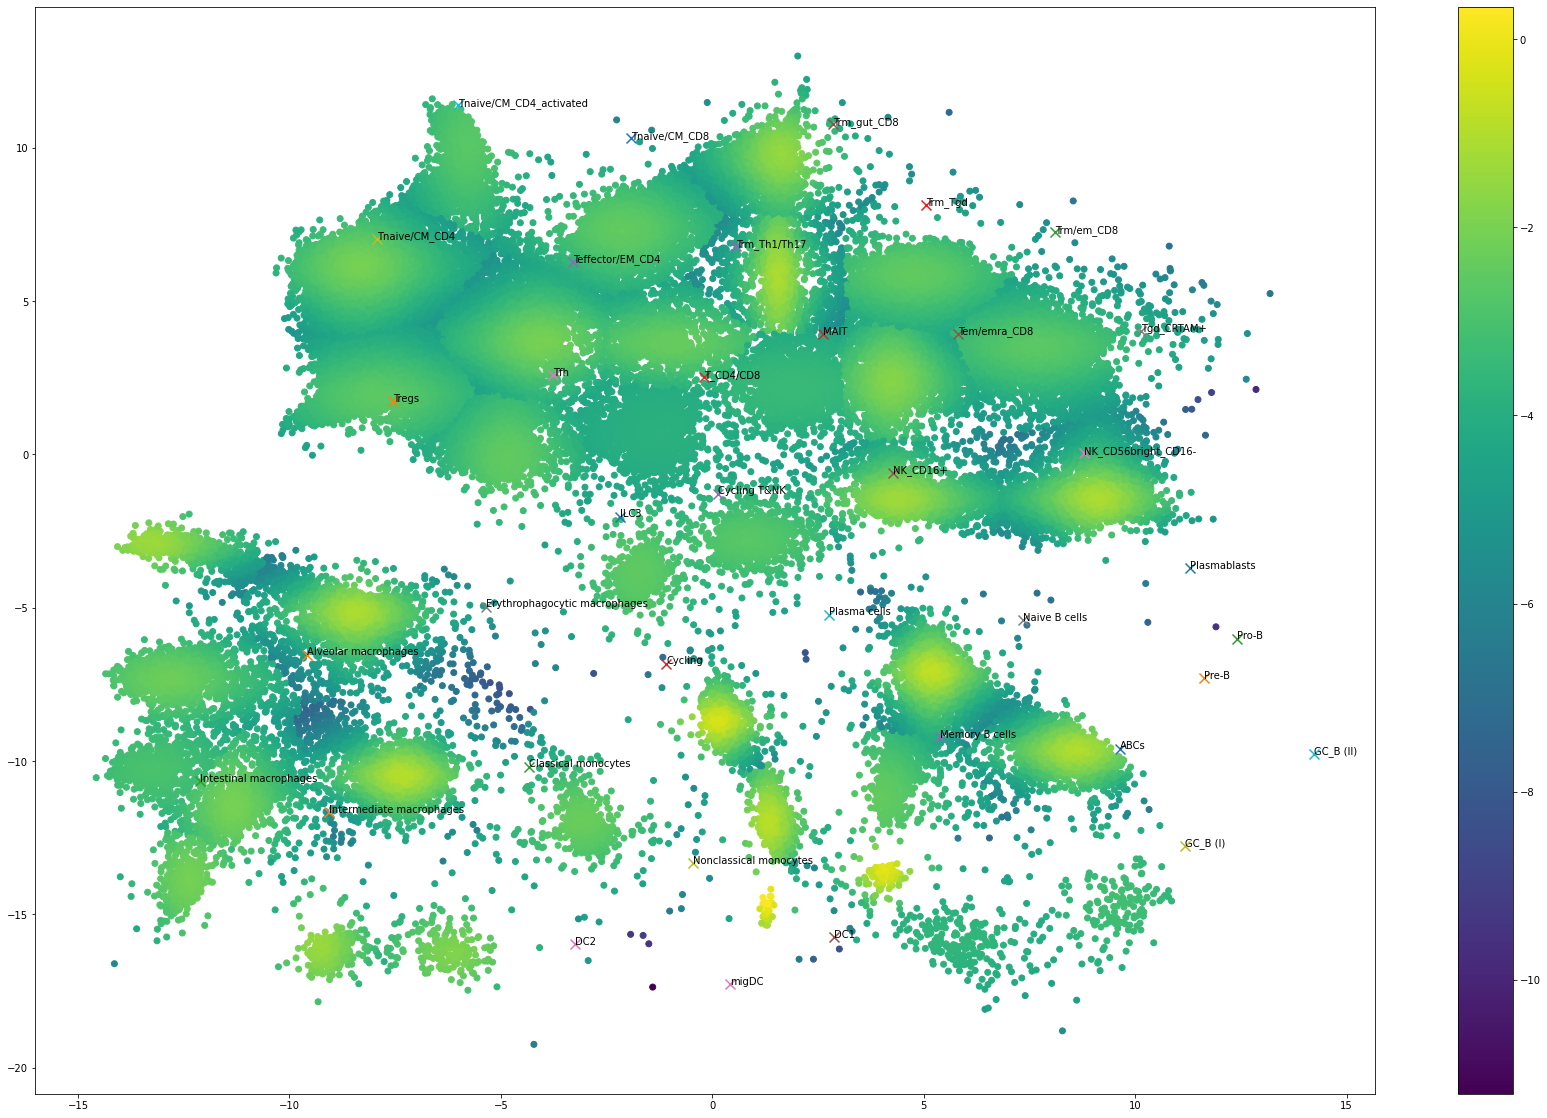

In [59]:
# Training
targets = torch.index_select(model.prototypes, 0, torch.tensor(training_embeddings_pred_labels_int))
log_vars = torch.log(torch.index_select(model.vars, 0, torch.tensor(training_embeddings_pred_labels_int)))
training_embedding_likelihoods = helper_fns.log_likelihood_student(torch.tensor(training_embeddings), targets, log_vars)
training_embedding_likelihoods = np.array(training_embedding_likelihoods.detach())

fig, ax = plt.subplots(figsize=(30, 20))
plt.rcParams["figure.autolayout"] = True
points = ax.scatter(np.array(training_embeddings)[:,0], np.array(training_embeddings)[:,1], c=training_embedding_likelihoods)
fig.colorbar(points)
for i in range(embedding_prototypes.shape[0]):
    ax.scatter(embedding_prototypes[i,0], embedding_prototypes[i,1], marker='x', s=100)
    ax.annotate(embedding_prototypes_labels[i], (embedding_prototypes[i,0], embedding_prototypes[i,1]))
plt.show()

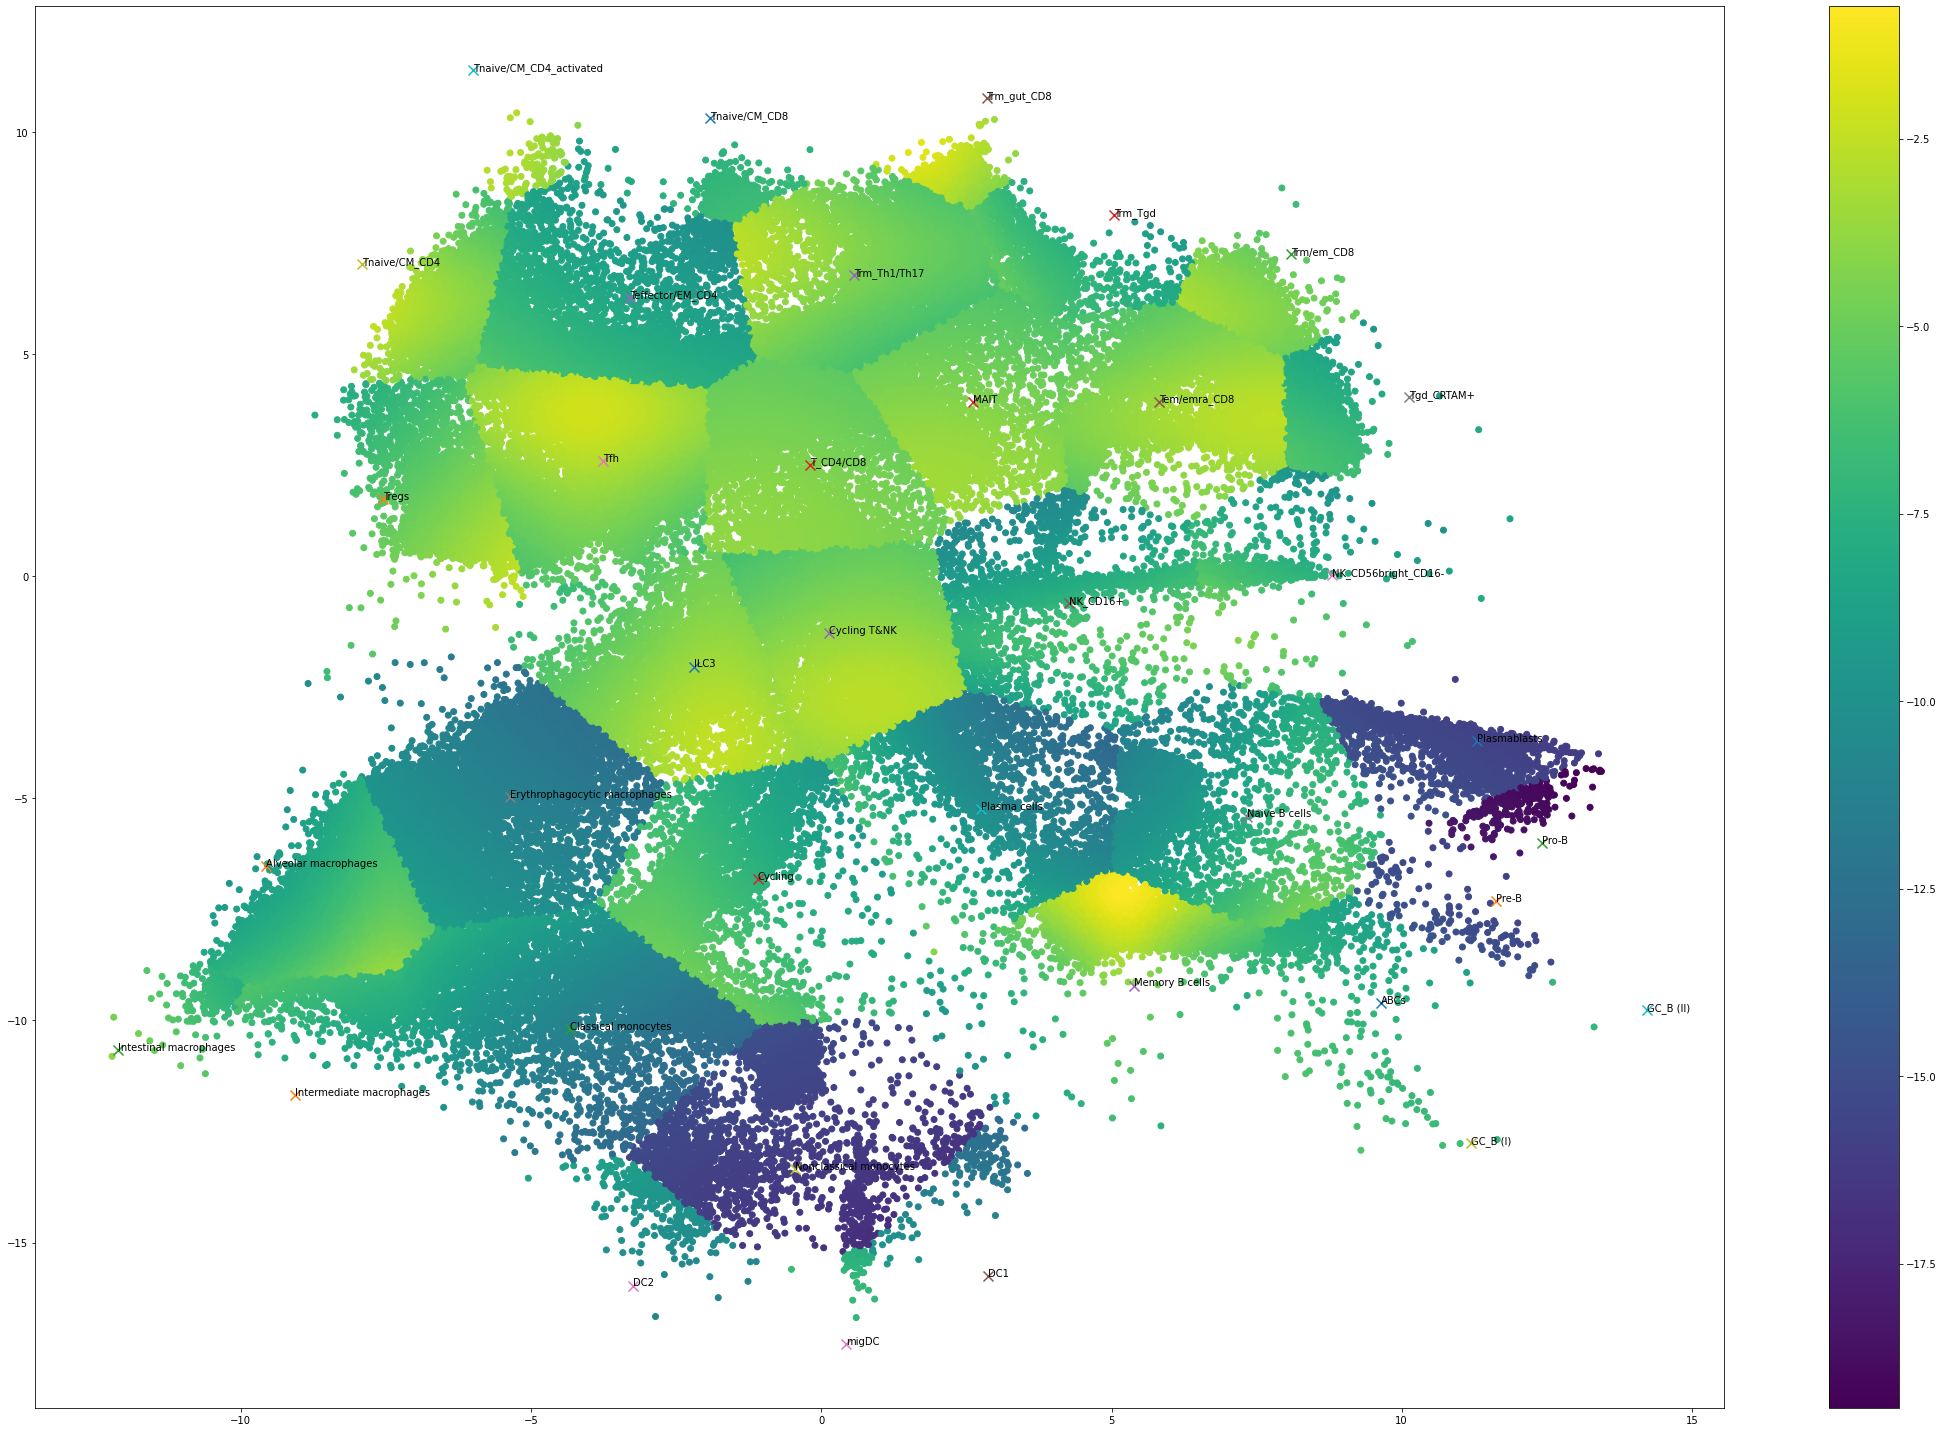

In [64]:
# Training
targets = torch.index_select(model.prototypes, 0, torch.tensor(encoder_celltype.transform(pred_labels_popv)))
log_vars = torch.log(torch.index_select(model.vars, 0, torch.tensor(encoder_celltype.transform(pred_labels_popv))))
training_embedding_likelihoods = helper_fns.log_likelihood_student(torch.tensor(embeddings_popv), targets, log_vars)
training_embedding_likelihoods = np.array(training_embedding_likelihoods.detach())

fig, ax = plt.subplots(figsize=(30, 20))
plt.rcParams["figure.autolayout"] = True
points = ax.scatter(np.array(embeddings_popv)[:,0], np.array(embeddings_popv)[:,1], c=training_embedding_likelihoods)
fig.colorbar(points)
for i in range(embedding_prototypes.shape[0]):
    ax.scatter(embedding_prototypes[i,0], embedding_prototypes[i,1], marker='x', s=100)
    ax.annotate(embedding_prototypes_labels[i], (embedding_prototypes[i,0], embedding_prototypes[i,1]))
plt.show()